In [1]:
import pandas as pd
import numpy as np
import re
from dataclasses import dataclass
from typing import List, Dict, Any, Optional, Literal, Sequence
from openai import OpenAI
import os
import json
import time
import sys
from pydantic import BaseModel, Field
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type
from tqdm import tqdm
from pathlib import Path  # Add this import


# Add project root to Python path for imports
project_root = os.path.abspath(os.path.join(os.path.dirname(__file__ if '__file__' in globals() else ''), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Now use absolute import
from src.variant_id_convertor import vv_annotate_variant
from src.utils import format_variant_for_prompt

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
ps3_bs3_df = pd.read_csv("../data/ps3_bs3_df_processed.csv")
print(f"len = {len(ps3_bs3_df)}")
ps3_bs3_df.head()

len = 1709


,#Variation,ClinVar Variation Id,Allele Registry Id,HGVS Expressions,HGNC Gene Symbol,Disease,Mondo Id,Mode of Inheritance,Assertion,Applied Evidence Codes (Met),...,PS3_abstracts,BS3_abstracts,PS3_urls,BS3_urls,PS3_urls_downloaded,BS3_urls_downloaded,PS3_level,BS3_level,PS3_comments,BS3_comments
0,NM_000277.2(PAH):c.1A>G (p.Met1Val),586,CA114360,"NM_000277.2:c.1A>G, NC_000012.12:g.102917130T>...",PAH,phenylketonuria,MONDO:0009861,Autosomal recessive inheritance,Pathogenic,"PM3, PP4_Moderate, PM2, PS3",...,Mutations in the human phenylalanine hydroxyla...,NaN,NaN,NaN,NaN,NaN,PS3,NaN,<3%,NaN
1,NM_000277.2(PAH):c.472C>T (p.Arg158Trp),102693,CA229570,"NM_000277.2:c.472C>T, NC_000012.12:g.102866633...",PAH,phenylketonuria,MONDO:0009861,Autosomal recessive inheritance,Pathogenic,"PP4_Moderate, PM2, PP3, PS3, PM3_Strong",...,To investigate the mutations of the phenylalan...,NaN,;;;;http://europepmc.org/backend/ptpmcrender.f...,NaN,http://europepmc.org/backend/ptpmcrender.fcgi?...,NaN,PS3,NaN,2% mutant enzyme activity in BioPKU,NaN
2,NM_000277.2(PAH):c.533A>G (p.Glu178Gly),92746,CA273110,"NM_000277.2:c.533A>G, NC_000012.12:g.102855309...",PAH,phenylketonuria,MONDO:0009861,Autosomal recessive inheritance,Pathogenic,"PS3_Supporting, PP4_Moderate, PM2_Supporting, ...",...,Mutations in the phenylalanine hydroxylase (PA...,NaN,NaN,NaN,NaN,NaN,PS3_supporting,NaN,Enzyme activity assay showed 39% residual phen...,NaN
3,NM_000277.2(PAH):c.963C>T (p.Leu321=),102911,CA229873,"NM_000277.2:c.963C>T, NC_000012.12:g.102846901...",PAH,phenylketonuria,MONDO:0009861,Autosomal recessive inheritance,Benign,"BS2, BS3_Supporting, BS1, BP7",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BS3_supporting,NaN,cDNA method demonstrates 98% and intinic syste...
4,NM_000277.2(PAH):c.194T>C (p.Ile65Thr),636,CA251544,"NM_000277.2:c.194T>C, NC_000012.12:g.102894893...",PAH,phenylketonuria,MONDO:0009861,Autosomal recessive inheritance,Pathogenic,"PP4_Moderate, PP3, PM3_Very Strong, PS3",...,Mutations at the phenylalanine hydroxylase (PA...,NaN,NaN,NaN,NaN,NaN,PS3,NaN,25% mutant enzyme activity in COS cells as com...,NaN


In [3]:

def _choose(row, ps3_col, bs3_col):
    return row[ps3_col] if pd.notna(row["PS3_level"]) else row[bs3_col]

def _split_multi(val):
    if pd.isna(val):
        return []
    return [x.strip() for x in str(val).split(";;") if x.strip()]

def remove_parentheses(text):
    """Remove text inside parentheses from a string."""
    if pd.isna(text):
        return text
    # Remove content inside parentheses (including nested parentheses)
    # This regex matches parentheses and their content
    return re.sub(r'\([^()]*\)', '', str(text)).strip()

# pick source columns based on PS3_level existence
tmp = ps3_bs3_df.copy()
tmp["pmids_src"] = tmp.apply(_choose, axis=1, ps3_col="PS3_pmids", bs3_col="BS3_pmids")
tmp["abstracts_src"] = tmp.apply(_choose, axis=1, ps3_col="PS3_abstracts", bs3_col="BS3_abstracts")
tmp["evidence"] = tmp.apply(
    lambda r: r["PS3_level"] if pd.notna(r["PS3_level"]) else r["BS3_level"],
    axis=1
)
# Also pick the relevant PS3/BS3 comments for each row
tmp["PS3_comments_src"] = tmp["PS3_comments"]
tmp["BS3_comments_src"] = tmp["BS3_comments"]

# Get #Variation column and remove parentheses from it
tmp["#Variation"] = tmp["#Variation"].apply(remove_parentheses)

# split pmids/abstracts
tmp["pmids_list"] = tmp["pmids_src"].apply(_split_multi)
tmp["abstracts_list"] = tmp["abstracts_src"].apply(_split_multi)

# explode and align pmids/abstracts; keep paired by position
def _explode_row(row):
    n = max(len(row["pmids_list"]), len(row["abstracts_list"]))
    pmids = row["pmids_list"] + [np.nan] * (n - len(row["pmids_list"]))
    abstracts = row["abstracts_list"] + [np.nan] * (n - len(row["abstracts_list"]))
    return pd.DataFrame({
        "pmid": pmids,
        "abstract": abstracts,
        "evidence": [row["evidence"]] * n,
        "#Variation": [row["#Variation"]] * n,
        "PS3_comments": [row["PS3_comments_src"]] * n,
        "BS3_comments": [row["BS3_comments_src"]] * n,
    })

ps3_bs3_df2 = (
    pd.concat([_explode_row(r) for _, r in tmp.iterrows()], ignore_index=True)
    .dropna(subset=["pmid", "abstract"], how="all")
)

ps3_bs3_df2 = ps3_bs3_df2.drop_duplicates(subset="pmid").reset_index(drop=True)

missing_abstracts = ps3_bs3_df2["abstract"].isna() | (ps3_bs3_df2["abstract"].astype(str).str.strip() == "")
print("total rows before drop:", len(ps3_bs3_df2))
print("rows with missing abstracts:", missing_abstracts.sum())

ps3_bs3_df2 = ps3_bs3_df2[~missing_abstracts].reset_index(drop=True)
print("total rows after drop:", len(ps3_bs3_df2))

ps3_bs3_df2['functional_experiment'] = 1
ps3_bs3_df2.head()

total rows before drop: 1087
rows with missing abstracts: 33
total rows after drop: 1054


,pmid,abstract,evidence,#Variation,PS3_comments,BS3_comments,functional_experiment
0,9450897,Mutations in the human phenylalanine hydroxyla...,PS3,NM_000277.2:c.1A>G,<3%,NaN,1
1,1307609,To investigate the mutations of the phenylalan...,PS3,NM_000277.2:c.472C>T,2% mutant enzyme activity in BioPKU,NaN,1
2,10429004,OBJECTIVE: To examine the relationship of phen...,PS3,NM_000277.2:c.472C>T,2% mutant enzyme activity in BioPKU,NaN,1
3,9634518,Phenylketonuria (PKU) and mild hyperphenylalan...,PS3,NM_000277.2:c.472C>T,2% mutant enzyme activity in BioPKU,NaN,1
4,17935162,Mutations in the phenylalanine hydroxylase (PA...,PS3_supporting,NM_000277.2:c.533A>G,Enzyme activity assay showed 39% residual phen...,NaN,1


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

# Filter data for the two models
models_to_plot = ['gpt-4o-mini', 'o4-mini']
df_filtered = res_df_matched_llmJudgeScored[res_df_matched_llmJudgeScored['model'].isin(models_to_plot)].copy()

# Convert string lists to actual lists (handle errors gracefully)
def safe_string_to_list(x):
    try:
        return string_to_list(x)
    except (ValueError, AttributeError):
        return []

df_filtered['_coverage_vote_scores_list'] = df_filtered['_coverage_vote_scores'].apply(safe_string_to_list)
df_filtered['_coverage_vote_confidences_list'] = df_filtered['_coverage_vote_confidences'].apply(safe_string_to_list)

# Explode the lists to create one row per vote score/confidence
# For scores
scores_data = []
for idx, row in df_filtered.iterrows():
    model = row['model']
    scores = row['_coverage_vote_scores_list']
    if isinstance(scores, list) and len(scores) > 0:
        for score in scores:
            # Convert to numeric, skip if invalid
            try:
                score_num = float(score) if score is not None else None
                if score_num is not None and not np.isnan(score_num):
                    scores_data.append({'model': model, 'coverage_score': score_num})
            except (ValueError, TypeError):
                continue

# For confidences
confidences_data = []
for idx, row in df_filtered.iterrows():
    model = row['model']
    confidences = row['_coverage_vote_confidences_list']
    if isinstance(confidences, list) and len(confidences) > 0:
        for conf in confidences:
            # Convert to numeric, skip if invalid
            try:
                conf_num = float(conf) if conf is not None else None
                if conf_num is not None and not np.isnan(conf_num):
                    confidences_data.append({'model': model, 'coverage_confidence': conf_num})
            except (ValueError, TypeError):
                continue

# Create DataFrames for plotting
df_scores = pd.DataFrame(scores_data)
df_confidences = pd.DataFrame(confidences_data)

# --- Publication-style defaults ---
mpl.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "axes.linewidth": 0.8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
ax1, ax2 = axes

# --- Plot 1: Coverage Scores Boxplot ---
box1 = ax1.boxplot(
    [df_scores[df_scores['model'] == model]['coverage_score'].values 
     for model in models_to_plot],
    labels=models_to_plot,
    patch_artist=True,
    widths=0.6,
    showmeans=True,
    meanline=True
)

# Style the boxes
colors = ['#0072B2', '#E69F00']  # Colorblind-friendly colors
for patch, color in zip(box1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(0.8)

# Style other elements
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(box1[element], color='black', linewidth=0.8)

ax1.set_ylabel('Coverage Score', fontsize=11)
ax1.set_xlabel('Model', fontsize=11)
ax1.set_title('Coverage Vote Scores by Model', fontsize=12, pad=10)
ax1.grid(True, axis='y', linestyle=':', linewidth=0.7, alpha=0.6)
ax1.set_axisbelow(True)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# --- Plot 2: Coverage Confidences Boxplot ---
box2 = ax2.boxplot(
    [df_confidences[df_confidences['model'] == model]['coverage_confidence'].values 
     for model in models_to_plot],
    labels=models_to_plot,
    patch_artist=True,
    widths=0.6,
    showmeans=True,
    meanline=True
)

# Style the boxes
for patch, color in zip(box2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(0.8)

# Style other elements
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(box2[element], color='black', linewidth=0.8)

ax2.set_ylabel('Coverage Confidence', fontsize=11)
ax2.set_xlabel('Model', fontsize=11)
ax2.set_title('Coverage Vote Confidences by Model', fontsize=12, pad=10)
ax2.grid(True, axis='y', linestyle=':', linewidth=0.7, alpha=0.6)
ax2.set_axisbelow(True)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Adjust layout
fig.tight_layout()

# Create output directory if it doesn't exist
output_dir = Path("../res/figures")
output_dir.mkdir(parents=True, exist_ok=True)

# Save figures
out_base_scores = output_dir / "coverage_scores_boxplot"
out_base_confidences = output_dir / "coverage_confidences_boxplot"
out_base_combined = output_dir / "coverage_scores_confidences_boxplots"

# Save combined figure
fig.savefig(f"{out_base_combined}.pdf", bbox_inches="tight")
fig.savefig(f"{out_base_combined}.png", dpi=300, bbox_inches="tight")

# Also save individual plots
fig1, ax1_only = plt.subplots(figsize=(5, 4), dpi=300)
box1_only = ax1_only.boxplot(
    [df_scores[df_scores['model'] == model]['coverage_score'].values 
     for model in models_to_plot],
    labels=models_to_plot,
    patch_artist=True,
    widths=0.6,
    showmeans=True,
    meanline=True
)
for patch, color in zip(box1_only['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(0.8)
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(box1_only[element], color='black', linewidth=0.8)
ax1_only.set_ylabel('Coverage Score', fontsize=11)
ax1_only.set_xlabel('Model', fontsize=11)
ax1_only.set_title('Coverage Vote Scores by Model', fontsize=12, pad=10)
ax1_only.grid(True, axis='y', linestyle=':', linewidth=0.7, alpha=0.6)
ax1_only.set_axisbelow(True)
ax1_only.spines['top'].set_visible(False)
ax1_only.spines['right'].set_visible(False)
fig1.tight_layout()
fig1.savefig(f"{out_base_scores}.pdf", bbox_inches="tight")
fig1.savefig(f"{out_base_scores}.png", dpi=300, bbox_inches="tight")
plt.close(fig1)

fig2, ax2_only = plt.subplots(figsize=(5, 4), dpi=300)
box2_only = ax2_only.boxplot(
    [df_confidences[df_confidences['model'] == model]['coverage_confidence'].values 
     for model in models_to_plot],
    labels=models_to_plot,
    patch_artist=True,
    widths=0.6,
    showmeans=True,
    meanline=True
)
for patch, color in zip(box2_only['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
    patch.set_edgecolor('black')
    patch.set_linewidth(0.8)
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(box2_only[element], color='black', linewidth=0.8)
ax2_only.set_ylabel('Coverage Confidence', fontsize=11)
ax2_only.set_xlabel('Model', fontsize=11)
ax2_only.set_title('Coverage Vote Confidences by Model', fontsize=12, pad=10)
ax2_only.grid(True, axis='y', linestyle=':', linewidth=0.7, alpha=0.6)
ax2_only.set_axisbelow(True)
ax2_only.spines['top'].set_visible(False)
ax2_only.spines['right'].set_visible(False)
fig2.tight_layout()
fig2.savefig(f"{out_base_confidences}.pdf", bbox_inches="tight")
fig2.savefig(f"{out_base_confidences}.png", dpi=300, bbox_inches="tight")
plt.close(fig2)

plt.show()

print(f"Figures saved to {output_dir}/")
print(f"  - {out_base_scores.name}.pdf and .png")
print(f"  - {out_base_confidences.name}.pdf and .png")
print(f"  - {out_base_combined.name}.pdf and .png (combined)")

In [4]:
# keep only pmids that have pdf papers in ../res/pdfs
pdf_dir = "../res/pdfs"
available_pmids = set(os.path.splitext(f)[0] for f in os.listdir(pdf_dir) if f.endswith(".pdf"))
ps3_bs3_df2 = ps3_bs3_df2[ps3_bs3_df2["pmid"].astype(str).isin(available_pmids)].reset_index(drop=True)
print("len ps3_bs3_df2:", len(ps3_bs3_df2))

len ps3_bs3_df2: 529


In [5]:

# Get unique variants
unique_variants = ps3_bs3_df2["#Variation"].unique()
print(f"Total rows: {len(ps3_bs3_df2)}")
print(f"Unique variants: {len(unique_variants)}")

# Process only unique variants
variant_info_map = {}
for variant in unique_variants:
    if pd.notna(variant):
        try:
            temp_res = vv_annotate_variant(**dict(variant=variant), select_transcripts="mane_select", resolve_rsids=True, timeout=10)
            variant_info_map[variant] = format_variant_for_prompt(temp_res)
        except Exception as e:
            print(f"Error processing variant {variant}: {e}")
            variant_info_map[variant] = None

# Map the results back to all rows in the dataframe
ps3_bs3_df2["variant_info"] = ps3_bs3_df2["#Variation"].map(variant_info_map)

ps3_bs3_df2.head()


Total rows: 529
Unique variants: 433
Error processing variant NM_004700.4:c.803_805CCT[1]: argument of type 'NoneType' is not iterable
Error processing variant ETHE1, EX4DEL: argument of type 'NoneType' is not iterable
Error processing variant m.14459G>A: argument of type 'NoneType' is not iterable
Error processing variant m.8344A>G: argument of type 'NoneType' is not iterable
Error processing variant m.3256C>T: argument of type 'NoneType' is not iterable
Error processing variant m.10010T>C: argument of type 'NoneType' is not iterable
Error processing variant m.5650G>A: argument of type 'NoneType' is not iterable
Error processing variant m.7511T>C: argument of type 'NoneType' is not iterable
Error processing variant m.583G>A: argument of type 'NoneType' is not iterable
Error processing variant m.15579A>G: argument of type 'NoneType' is not iterable
Error processing variant NC_000005.10:g._del: argument of type 'NoneType' is not iterable
Error processing variant m.14674T>C: argument of 

,pmid,abstract,evidence,#Variation,PS3_comments,BS3_comments,functional_experiment,variant_info
0,9634518,Phenylketonuria (PKU) and mild hyperphenylalan...,PS3,NM_000277.2:c.472C>T,2% mutant enzyme activity in BioPKU,NaN,1,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10286..."
1,3615198,Classical Phenylketonuria (PKU) is an autosoma...,PS3,NM_000277.2:c.1315+1G>A,abolishes PAH activity due to protein instability,NaN,1,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10284..."
2,15319459,Tetrahydrobiopterin (BH4)-responsive phenylala...,PS3,NM_000277.1:c.721C>T,In vitro PAH R241C mutant was found to have 25...,NaN,1,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10285..."
3,24401910,Phenylalanine hydroxylase (PAH) deficiency is ...,PS3,NM_000277.1:c.755G>A,BioPKU 3% enzyme activity; 3.8% residual activity,NaN,1,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10285..."
4,29706350,Phosphatase and tensin homolog (PTEN) is a tum...,BS3_supporting,NM_000314.6:c.1052_1054delTAG,NaN,In vitro or in vivo functional study or studie...,1,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8796..."


In [7]:
ps3_bs3_df3 = ps3_bs3_df2.dropna(subset=["variant_info"]).reset_index(drop=True)
print(f'len ps3_bs3_df3 after removing variants that couldnt be matched: {len(ps3_bs3_df3)}')
ps3_bs3_df3.to_csv("../data/ps3_bs3_df_processed_withVariantIDs.csv", index=False)
ps3_bs3_df3.head()

len ps3_bs3_df3 after removing variants that couldnt be matched: 466


,pmid,abstract,evidence,#Variation,PS3_comments,BS3_comments,functional_experiment,variant_info
0,9634518,Phenylketonuria (PKU) and mild hyperphenylalan...,PS3,NM_000277.2:c.472C>T,2% mutant enzyme activity in BioPKU,NaN,1,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10286..."
1,3615198,Classical Phenylketonuria (PKU) is an autosoma...,PS3,NM_000277.2:c.1315+1G>A,abolishes PAH activity due to protein instability,NaN,1,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10284..."
2,15319459,Tetrahydrobiopterin (BH4)-responsive phenylala...,PS3,NM_000277.1:c.721C>T,In vitro PAH R241C mutant was found to have 25...,NaN,1,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10285..."
3,24401910,Phenylalanine hydroxylase (PAH) deficiency is ...,PS3,NM_000277.1:c.755G>A,BioPKU 3% enzyme activity; 3.8% residual activity,NaN,1,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10285..."
4,29706350,Phosphatase and tensin homolog (PTEN) is a tum...,BS3_supporting,NM_000314.6:c.1052_1054delTAG,NaN,In vitro or in vivo functional study or studie...,1,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8796..."


In [7]:
ps3_bs3_df3 = pd.read_csv("../data/ps3_bs3_df_processed_withVariantIDs.csv")

In [8]:
SYSTEM_STEP2_PDF = r"""
You are a clinical variant functional-evidence extractor for ACMG/AMP guidelines PS3/BS3 criteria.

INPUTS
- TARGET_VARIANT: gene + identifiers (any of rsID, HGVSg, chr_pos_ref_alt,
  HGVSc, HGVSp, aliases).
- PAPER: a full PDF (may include many variants).

GOAL
- Find all plausible variant-level functional experiments that might correspond to the TARGET_VARIANT. Read all PDF (text, tables, figure captions, and figure panels/embedded labels)
- Be SENSITIVE: when in doubt, extract and clearly mark uncertainty.
- Do NOT hallucinate data.

OUTPUT
- Return ONLY valid JSON that matches the schema exactly.
- Use double quotes for all keys and strings.
- No commentary outside JSON.

────────────────────────────────────
1. VARIANT MATCHING (SOFT GATE)
────────────────────────────────────
Build an equivalents set for the TARGET_VARIANT (without inventing mappings):
- Same rsID
- Same genomic coordinates (exact chr:pos:ref:alt or HGVSg as given)
- Same cDNA change (c.notation; allow formatting variants)
- Same protein change (same ref AA, same position, same alt AA;
  allow 1-letter ↔ 3-letter and formatting variants)

Do NOT:
- Change genome build
- Renumber across transcripts unless the paper explicitly gives both
- Guess transcript IDs

Match tiers (you can stop when one is clearly satisfied):

1) STRICT MATCH → status = "matched"
   - Exact rsID, genomic, cDNA, or protein match from the equivalents set,
     in the correct gene.
   - match_type = "rsid" / "genomic" / "cdna" / "protein" / "multiple"
   - confidence:
     - "high": rsID or genomic
     - "medium": cDNA or protein + clear gene context
     - "low": identifier match but weak context

2) SINGLE VARIANT STUDY → status = "single_variant_study_matching"
   - Functional experiments in this gene clearly test ONE specific variant only.
   - No other specific variants appear in functional results.
   - confidence:
     - "medium" if gene and clinical context are clear
     - "low" if context is weaker
   - match_type = "single_variant_study"

3) HEURISTIC MATCH → status = "heuristic_matching"
   Use for plausible, non-strict matches in the same gene. Count applicable clues:

   Clues:
    - Same amino-acid substitution (same ref AA, position, alt AA) but written
    in words or non-standard notation (e.g. “R158W mutant”, “R158→W”).
    - Explicit numbering / isoform / precursor→mature mapping that links positions
    to the same amino acid change.
    - Different cDNA / protein numbering that the paper directly ties together
    (e.g. “c.472C>T (R158W)”).
    - Shorthand label (“mut1”, “A”, etc.) that is expanded elsewhere to a notation
    matching the TARGET_VARIANT equivalents.
    - Table / figure / text cross-reference that explicitly equates two labels
    as the same variant.
    - Multiplex / saturation screen where the authors systematically test single
    substitutions and the tested set clearly includes the TARGET codon / position
    (e.g. “all single-amino-acid substitutions at residue 158”).

    Never call heuristic_matching based only on:
    - Same exon / domain / region, “nearby” codon, or vague proximity.
    - Gene-level statements with no specific variant label.

   - match_type = "heuristic"
   - confidence: "low" if 1 clue; "medium" if ≥2 clues

4) NO PLAUSIBLE VARIANT → status = "variant_matching_unsuccessful"
   - Use ONLY when you find no specific variant in this gene that could
     reasonably be the TARGET_VARIANT.
   - In this case: experiments = [] and overall_evidence.evidence_level =
     "not_clear" and evidence_strength = "not_clear".

IMPORTANT SENSITIVITY RULE:
- If you see any specific variant in the SAME GENE that could plausibly be the
  TARGET_VARIANT, you SHOULD:
  - Assign "matched", "single_variant_study_matching", or "heuristic_matching"
    with appropriate (often low) confidence.
  - Extract its experiments.
  - Explain uncertainty in variant_match.notes and overall_evidence.basis.
- Only use "variant_matching_unsuccessful" when there is truly no plausible
  candidate.

────────────────────────────────────
2. EXPERIMENT EXTRACTION
────────────────────────────────────
Extract experiments ONLY for the variant(s) linked to the TARGET_VARIANT by
your chosen status (matched / single_variant_study_matching / heuristic_matching).

INCLUDE:
- Experiments where the specific variant label (e.g. "R158W", "mut1",
  "c.472C>T") has its own row, bar, lane, or result.
- Variant-level results in tables, figures, or text.

EXCLUDE:
- Purely in silico predictions.
- Case reports or association studies with no functional assay.
- Results where variants are pooled and no individual variant result is given.

For each experiment, record:
- What the assay is (assay)
- The system used (system)
- How the variant material was obtained (variant_material)
- The measured endpoint (readout)
- The explicit comparator (normal_comparator: WT/healthy/threshold)
- The functional direction and any numbers (result.direction and
  result.effect_size_and_stats)
- Controls and validation details (controls_and_validation)
- Authors’ explicit conclusion about the variant (authors_conclusion)
- Where it appears (where_in_paper)
- Limitations stated in the paper (caveats)
- Exact variant label in the paper (paper_variant_label)
- How strongly you link that label to the TARGET_VARIANT
  (variant_link_confidence).

If you find NO functional assay on the matched variant:
- experiments = []
- overall_evidence.evidence_level = "not_clear"
- overall_evidence.evidence_strength = "not_clear"
- State this in overall_evidence.basis.

────────────────────────────────────
3. PS3 / BS3 / not_clear
────────────────────────────────────
Definitions:
- PS3: Variant shows a functionally abnormal result (for example vs. a normal comparator),
consistent with a damaging effect and disease mechanism.
- BS3: Variant shows functionally normal result (for example vs. a normal comparator).
- not_clear: unclear direction, conflicting or insufficient information.

Strength (very_strong / strong / moderate / supporting / not_clear):
- supporting: comparator present + basic controls described (WT ± positive/null) but limited validation
- moderate: well-established assay with clear controls/replication and/or multiple validation controls described
- strong/very_strong: the paper provides rigorous clinical validation/calibration supporting high confidence
  (e.g., multiple known benign/pathogenic controls with clear thresholds or explicit calibration).

If evidence_level = "not_clear":
- evidence_strength MUST be "not_clear".

────────────────────────────────────
4. SUMMARY
────────────────────────────────────
In summary:
- Be generous in extraction when the variant is plausibly the TARGET_VARIANT.
- Use status, confidence, variant_link_confidence, and notes to mark how sure
  you are.
- Never invent experiments or numbers.
- Output must be valid JSON according to the schema, with no extra keys.
"""

USER_TEMPLATE_PDF = """TARGET_VARIANT: {target_variant_string}

Attached: 1 full-text PDF paper.

Follow the system instructions to:
- Match the TARGET_VARIANT to variant labels in the paper,
- Extract all plausible variant-level functional experiments for that variant,
- Summarize PS3/BS3 evidence and strength.

Return ONLY valid JSON that matches the schema exactly.
Do NOT add any text outside the JSON object.
"""


VARIANT_FUNCTIONAL_SCHEMA = {
    "type": "object",
    "additionalProperties": False,
    "required": [
        "target_variant_input",
        "variant_match",
        "experiments",
        "overall_evidence",
        "summary"
    ],
    "properties": {
        "target_variant_input": {
            "type": "string",
            "description": "Raw TARGET_VARIANT input string"
        },
        "variant_match": {
            "type": "object",
            "additionalProperties": False,
            "required": [
                "status",
                "confidence",
                "match_type",
                "matched_strings_in_paper",
                "equivalents_used",
                "where_in_paper",
                "notes"
            ],
            "properties": {
                "status": {
                    "type": "string",
                    "enum": [
                        "matched",
                        "single_variant_study_matching",
                        "heuristic_matching",
                        "variant_matching_unsuccessful"
                    ],
                    "description": "Overall matching outcome for the TARGET_VARIANT"
                },
                "confidence": {
                    "type": "string",
                    "enum": ["high", "medium", "low", "not_clear"],
                    "description": "Overall confidence that the matched variant(s) in the paper correspond to the TARGET_VARIANT"
                },
                "match_type": {
                    "type": "string",
                    "enum": [
                        "rsid",
                        "genomic",
                        "cdna",
                        "protein",
                        "multiple",
                        "single_variant_study",
                        "heuristic",
                        "not_clear"
                    ],
                    "description": "Primary identifier or pattern used to link the paper variant(s) to the TARGET_VARIANT"
                },
                "matched_strings_in_paper": {
                    "type": "array",
                    "items": {"type": "string"},
                    "description": "Exact matching strings as they appear in the paper (variant labels, rsIDs, HGVS, etc.)"
                },
                "equivalents_used": {
                    "type": "array",
                    "items": {"type": "string"},
                    "description": "List of equivalent forms of TARGET_VARIANT used in the search (e.g. rsID, cDNA, protein)"
                },
                "where_in_paper": {
                    "type": "array",
                    "items": {"type": "string"},
                    "description": "Locations of the matched strings (e.g. 'Table 1', 'Fig 2B', 'Results paragraph 3')"
                },
                "notes": {
                    "type": "array",
                    "items": {"type": "string"},
                    "description": "Short notes explaining matching rationale and any ambiguity"
                }
            }
        },
        "experiments": {
            "type": "array",
            "description": "Functional experiments for the variant(s) linked to the TARGET_VARIANT (may be empty)",
            "items": {
                "type": "object",
                "additionalProperties": False,
                "required": [
                    "assay",
                    "system",
                    "variant_material",
                    "readout",
                    "normal_comparator",
                    "result",
                    "controls_and_validation",
                    "authors_conclusion",
                    "where_in_paper",
                    "caveats",
                    "paper_variant_label",
                    "variant_link_confidence"
                ],
                "properties": {
                    "assay": {
                        "type": ["string", "null"],
                        "description": "Assay type (e.g. enzyme activity, minigene splicing, binding, localization)"
                    },
                    "system": {
                        "type": ["string", "null"],
                        "description": "Experimental system (e.g. HEK293 cells, patient fibroblasts, mouse model, yeast, purified protein)"
                    },
                    "variant_material": {
                        "type": ["string", "null"],
                        "description": "Source of the variant material (expression construct, patient sample, engineered cells, etc.)"
                    },
                    "readout": {
                        "type": ["string", "null"],
                        "description": "Measured endpoint with units where available (e.g. activity %, mRNA level, fluorescence)"
                    },
                    "normal_comparator": {
                        "type": ["string", "null"],
                        "description": "Explicit comparator defining normal function (WT, healthy control, threshold); required to apply PS3/BS3"
                    },
                    "result": {
                        "type": "object",
                        "additionalProperties": False,
                        "required": [
                            "direction",
                            "effect_size_and_stats"
                        ],
                        "properties": {
                            "direction": {
                                "type": "string",
                                "enum": [
                                    "functionally_abnormal",
                                    "functionally_normal",
                                    "intermediate",
                                    "mixed",
                                    "unclear"
                                ],
                                "description": "Functional impact relative to the comparator"
                            },
                            "effect_size_and_stats": {
                                "type": ["string", "null"],
                                "description": "Quantitative details (e.g. variant vs WT, fold change, n, error bars, p-values) as reported"
                            }
                        }
                    },
                    "controls_and_validation": {
                        "type": ["string", "null"],
                        "description": "Information on assay controls, replicates, known pathogenic/benign controls, and any validation metrics"
                    },
                    "authors_conclusion": {
                        "type": ["string", "null"],
                        "description": "Authors' interpretation of the functional effect of the variant in this experiment"
                    },
                    "where_in_paper": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "Specific locations of this experiment (e.g. 'Fig 3B', 'Table 2 row 4', 'Results p.5')"
                    },
                    "caveats": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "Limitations or caveats explicitly mentioned in the paper for this experiment"
                    },
                    "paper_variant_label": {
                        "type": ["string", "null"],
                        "description": "Exact variant label used in the paper for this experiment (e.g. 'R158W', 'p.Arg158Trp', 'mut1')"
                    },
                    "variant_link_confidence": {
                        "type": "string",
                        "enum": ["high", "medium", "low"],
                        "description": "Confidence that this paper_variant_label corresponds to the TARGET_VARIANT for this experiment"
                    }
                }
            }
        },
        "overall_evidence": {
            "type": "object",
            "additionalProperties": False,
            "required": [
                "evidence_level",
                "evidence_strength",
                "odds_path",
                "validation_basis",
                "basis"
            ],
            "properties": {
                "evidence_level": {
                    "type": "string",
                    "enum": ["PS3", "BS3", "not_clear"],
                    "description": "Overall functional evidence classification for the TARGET_VARIANT in this paper"
                },
                "evidence_strength": {
                    "type": "string",
                    "enum": [
                        "very_strong",
                        "strong",
                        "moderate",
                        "supporting",
                        "not_clear"
                    ],
                    "description": "Strength of the functional evidence; must be 'not_clear' if evidence_level is 'not_clear'"
                },
                "odds_path": {
                    "type": ["number", "null"],
                    "description": "OddsPath value if explicitly reported; otherwise null"
                },
                "validation_basis": {
                    "type": ["string", "null"],
                    "description": "Justification for the chosen evidence_strength (validation controls, CLIA assay, statistics, etc.)"
                },
                "basis": {
                    "type": "string",
                    "description": "Short rationale summarizing comparator, functional direction, disease mechanism consistency, and any matching uncertainty"
                }
            }
        },
        "summary": {
            "type": "string",
            "description": "2–5 sentence narrative: how the variant was matched, what experiments show, and the PS3/BS3 call and strength"
        }
    }
}



In [9]:
client = OpenAI()


def save_json_to_path(json_obj: Any, file_path: str) -> None:
    Path(file_path).parent.mkdir(parents=True, exist_ok=True)
    with open(file_path, "w") as f:
        json.dump(json_obj, f)


def load_json_from_path(file_path: str) -> Any:
    with open(file_path, "r") as f:
        return json.load(f)


def _fallback_result(
    pmid: str,
    variant_id: str,
    model: str,
    error: str,
) -> Dict[str, Any]:
    """
    Keep this aligned with whatever your downstream expects.
    If your strict schema requires additional keys, add them here too.
    """
    return {
        "pmid": pmid,
        "model": model,
        "variant_info": variant_id,
        "variant_id": variant_id,  # kept for backward-compat with your previous output
        "variant_match": None,
        "summary": None,
        "basis": None,
        "functional_strength": None,
        "odds_path": None,
        "_error": error,  # helpful for debugging; remove if you want schema-only outputs
    }


def upload_pdf_once(pdf_path, upload_cache: Dict[str, str]) -> str:
    """
    Uploads a PDF once and caches the resulting file_id keyed by absolute path.
    """
    pdf_path = pdf_path.resolve()
    cache_key = str(pdf_path)
    if cache_key in upload_cache:
        return upload_cache[cache_key]

    if not pdf_path.exists():
        raise FileNotFoundError(f"Missing PDF: {pdf_path}")

    # Recommended purpose for model-usable files
    up = client.files.create(
        file=pdf_path.open("rb"),
        purpose="assistants",
    )
    upload_cache[cache_key] = up.id
    return up.id


def llm_call_pdf_with_file_id(
    pmid: str,
    variant_id: str,
    file_id: str,
    model: str = "gpt-4o-mini",
    debug: bool = False,
) -> Dict[str, Any]:
    """
    Calls the model using a pre-uploaded file_id.
    Includes robust handling for empty output_text and JSON parse failures.
    """
    user_text = USER_TEMPLATE_PDF.format(target_variant_string=variant_id)

    try:
        resp = client.responses.create(
            model=model,
            instructions=SYSTEM_STEP2_PDF,
            input=[
                {
                    "role": "user",
                    "content": [
                        {"type": "input_file", "file_id": file_id},
                        {"type": "input_text", "text": user_text},
                    ],
                }
            ],
            text={
                "format": {
                    "type": "json_schema",
                    "name": "variant_functional_summary",
                    "strict": True,
                    "schema": VARIANT_FUNCTIONAL_SCHEMA,
                }
            },
            store=False,
        )

        # Structured Outputs should give valid JSON here, but guard anyway:
        if not getattr(resp, "output_text", None):
            # Optional debug: print the raw response object representation
            if debug:
                print(f"[DEBUG] Empty output_text for PMID={pmid}, variant={variant_id}, model={model}")
                try:
                    print("[DEBUG] resp.output:", resp.output)
                except Exception:
                    pass
            raise ValueError("Empty model output_text (possible schema failure or truncation)")

        parsed = json.loads(resp.output_text)

        # Add your tracking fields consistently
        if isinstance(parsed, dict):
            parsed["pmid"] = pmid
            parsed["model"] = model
            parsed["variant_info"] = variant_id
            parsed.setdefault("variant_id", variant_id)

        return parsed

    except Exception as e:
        if debug:
            print(f"[DEBUG] Error for PMID={pmid}, variant={variant_id}, model={model}: {e}")
        return _fallback_result(pmid=pmid, variant_id=variant_id, model=model, error=str(e))


def run_llm_call_pdf(
    df,
    models: List[str],
    save_every: int = 50,
    save_path: Optional[str] = "../data/ps3_bs3_df_processed_withVariantIDs_llmClassifier.json",
    pdf_dir: str = "../res/pdfs",
    debug: bool = False,
) -> List[Dict[str, Any]]:
    """
    Improvements implemented:
    - Upload each PMID PDF once; reuse file_id across variants and models.
    - Upload purpose set to 'assistants' (recommended for model inputs).
    - Guard against empty output_text + robust JSON parsing.
    - Adds stable tracking fields in every output row.
    """
    out: List[Dict[str, Any]] = []
    pdf_dir_path = Path(pdf_dir)

    upload_cache: Dict[str, str] = {}  # key: absolute pdf path, value: file_id

    # Save counter independent of df index (df index may not be 0..N)
    processed_count = 0

    for model in models:
        for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing variants ({model})"):
            pmid = str(row["pmid"])
            variant_id = str(row["variant_info"])
            pdf_path = (pdf_dir_path / f"{pmid}.pdf")

            try:
                file_id = upload_pdf_once(pdf_path, upload_cache)
                result = llm_call_pdf_with_file_id(
                    pmid=pmid,
                    variant_id=variant_id,
                    file_id=file_id,
                    model=model,
                    debug=debug,
                )
            except Exception as e:
                # Upload failure (missing/bad file) lands here
                if debug:
                    print(f"[DEBUG] Upload/read error for PMID={pmid}: {e}")
                result = _fallback_result(pmid=pmid, variant_id=variant_id, model=model, error=str(e))

            out.append(result)
            processed_count += 1

            if save_path is not None and processed_count % save_every == 0:
                save_json_to_path(out, save_path)

    # Final save at the end (so you always have the latest)
    if save_path is not None:
        save_json_to_path(out, save_path)

    return out


In [8]:
res_dict = run_llm_call_pdf(ps3_bs3_df3, models = ['gpt-4o-mini', 'o4-mini'])


Processing variants (o4-mini): 100%|██████████| 463/463 [4:08:34<00:00, 32.21s/it]   


In [9]:
res_dict

[{'target_variant_input': 'Gene: PAH, chr_pos_ref_alt (hg38): chr12_102866633_G_A, chr_pos_ref_alt (hg37): chr12_103260411_G_A, HGVSg (hg38): g.102866633G>A, HGVSg (hg37): g.103260411G>A, rsID: rs75166491, HGVSc: c.472C>T, HGVSp (3-letter): p.Arg158Trp, HGVSp (1-letter): p.R158W',
  'variant_match': {'status': 'matched',
   'confidence': 'medium',
   'match_type': 'protein',
   'matched_strings_in_paper': ['R158Q', 'R158W', 'R158X'],
   'equivalents_used': ['rsID', 'genomic', 'cDNA', 'protein'],
   'where_in_paper': ['Appendix', 'Table 1'],
   'notes': ['R158W is considered a variant of interest due to its associated phenotype classifications.',
    'Multiple classifications of this variant exist, leading to some ambiguity in functional implications.']},
  'experiments': [{'assay': 'enzyme activity',
    'system': 'human liver extracts',
    'variant_material': 'patient samples',
    'readout': 'enzyme activity levels (% of WT)',
    'normal_comparator': 'WT',
    'result': {'direction

In [23]:
def convert_result_list_to_df(result_list):
    """
    Convert a list of result dictionaries to a pandas DataFrame.
    - Robust to heterogeneous dict schemas (missing keys -> NA).
    - Flattens nested dictionaries (e.g., variant_match_status).
    - Converts lists to strings:
        - list of scalars -> "a;;b;;c"
        - list of dicts   -> '{"k":...};;{"k":...}'
    """
    import pandas as pd
    import json

    if result_list is None:
        return pd.DataFrame()

    # 1) Collect union of top-level keys so missing keys become NA later
    all_top_keys = set()
    for item in result_list:
        if isinstance(item, dict):
            all_top_keys |= set(item.keys())

    # 2) Pad each row with missing top-level keys -> None
    padded = []
    for item in result_list:
        if not isinstance(item, dict):
            # If something non-dict sneaks in, keep it as a single-column row
            padded.append({"_value": item})
            continue
        row = dict(item)
        for k in all_top_keys:
            row.setdefault(k, None)
        padded.append(row)

    # 3) Flatten nested dicts (variant_match, overall_evidence, etc.)
    df = pd.json_normalize(padded, sep="_")

    # 4) Stringify lists (including lists of dicts)
    def stringify_list(x):
        if not isinstance(x, list):
            return x
        if len(x) == 0:
            return ""  # or pd.NA, up to you
        if all(isinstance(el, dict) for el in x):
            return ";;".join(json.dumps(el, ensure_ascii=False, sort_keys=True) for el in x)
        return ";;".join(map(str, x))

    for col in df.columns:
        df[col] = df[col].apply(stringify_list)

    # 5) Use pandas' native NA type for missing values
    df = df.convert_dtypes()

    return df


In [24]:
res_df = convert_result_list_to_df(res_dict)

# Remove columns 'target_variant_input' and 'variant_id' if present
cols_to_drop = [col for col in ['target_variant_input', 'variant_id']]
res_df = res_df.drop(columns=cols_to_drop)

# put variant_info in the first column
res_df = res_df[['variant_info'] + [col for col in res_df.columns if col != 'variant_info']]

print(f"len res_df: {len(res_df)}")

res_df.head()

len res_df: 926


,variant_info,experiments,summary,pmid,model,functional_strength,odds_path,basis,_error,variant_match_status,...,variant_match_equivalents_used,variant_match_where_in_paper,variant_match_notes,overall_evidence_evidence_level,overall_evidence_evidence_strength,overall_evidence_odds_path,overall_evidence_validation_basis,overall_evidence_basis,variant_match,overall_evidence
0,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10286...","{""assay"": ""enzyme activity"", ""authors_conclusi...",The R158W variant in the PAH gene was matched ...,9634518,gpt-4o-mini,None,None,None,<NA>,matched,...,rsID;;genomic;;cDNA;;protein,Appendix;;Table 1,R158W is considered a variant of interest due ...,PS3,strong,<NA>,Validation based on multiple functional assays...,The R158W variant shows a significant reductio...,<NA>,<NA>
1,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10284...","{""assay"": ""PAH activity assay"", ""authors_concl...",The study matches the TARGET_VARIANT through a...,3615198,gpt-4o-mini,None,None,None,<NA>,single_variant_study_matching,...,chr12_102840399_C_T;;g.102840399C>T;;c.1315+1G...,Introduction;;Results;;Discussion,The paper identifies a GT to AT transition at ...,PS3,strong,<NA>,Evidence of complete absence of PAH activity i...,The variant leads to a frameshift mutation whi...,<NA>,<NA>
2,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10285...",<NA>,<NA>,15319459,gpt-4o-mini,None,None,None,Error code: 400 - {'error': {'message': 'The f...,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10285...",<NA>,<NA>,24401910,gpt-4o-mini,None,None,None,Error code: 400 - {'error': {'message': 'The f...,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8796...",,No matching variant found corresponding to the...,29706350,gpt-4o-mini,None,None,None,<NA>,variant_matching_unsuccessful,...,,,No specific variant corresponding to TARGET_VA...,not_clear,not_clear,<NA>,<NA>,No functional experiments were found that prov...,<NA>,<NA>


In [26]:
res_df.to_csv(
    "../data/ps3_bs3_df_processed_withVariantIDs_llmClassifier.tsv",
    index=False,
    sep="\t",
    escapechar="\\",
    quoting=3  # csv.QUOTE_NONE
)


### Load and calculate performances

In [1]:
import pandas as pd

res_df = pd.read_csv("../data/ps3_bs3_df_processed_withVariantIDs_llmClassifier.tsv", sep="\t")

# ground truth df
ps3_bs3_df3 = pd.read_csv("../data/ps3_bs3_df_processed_withVariantIDs.csv")[["evidence", "PS3_comments", "BS3_comments", "variant_info", "pmid"]]

# break evidence into two columns including evidence_level and evidence_strength separated via _    
ps3_bs3_df3[["evidence_level", "evidence_strength"]] = ps3_bs3_df3["evidence"].str.split("_", expand=True)

# drop evidence column
ps3_bs3_df3.drop(columns=["evidence"], inplace=True)

ps3_bs3_df3.rename(columns={"evidence_level":"evidence_level_clingen", "evidence_strength":"evidence_strength_clingen",
                     "PS3_comments": "PS3_comments_clingen", "BS3_comments": "BS3_comments_clingen"}, inplace=True)

# merge
res_df = res_df.merge(ps3_bs3_df3, on=["pmid", "variant_info"], how="left")


In [2]:
ps3_bs3_df3

,PS3_comments_clingen,BS3_comments_clingen,variant_info,pmid,evidence_level_clingen,evidence_strength_clingen
0,2% mutant enzyme activity in BioPKU,NaN,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10286...",9634518,PS3,None
1,abolishes PAH activity due to protein instability,NaN,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10284...",3615198,PS3,None
2,In vitro PAH R241C mutant was found to have 25...,NaN,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10285...",15319459,PS3,None
3,BioPKU 3% enzyme activity; 3.8% residual activity,NaN,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10285...",24401910,PS3,None
4,NaN,In vitro or in vivo functional study or studie...,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8796...",29706350,BS3,supporting
...,...,...,...,...,...,...
461,In vitro and in vivo functional studies provid...,NaN,"Gene: TNNT2, chr_pos_ref_alt (hg38): chr1_2013...",8958207,PS3,moderate
462,In vitro and in vivo functional studies provid...,NaN,"Gene: TNNT2, chr_pos_ref_alt (hg38): chr1_2013...",9637714,PS3,moderate
463,In vitro and in vivo functional studies provid...,NaN,"Gene: TNNT2, chr_pos_ref_alt (hg38): chr1_2013...",10617660,PS3,moderate
464,In vitro and in vivo functional studies provid...,NaN,"Gene: TNNT2, chr_pos_ref_alt (hg38): chr1_2013...",15568820,PS3,moderate


In [3]:
print(f"shape res_df: {res_df.shape}")

# drop column that are only NA
res_df = res_df.dropna(axis=1, how='all')

print(f"shape res_df: {res_df.shape}")

res_df.head()


shape res_df: (926, 27)
shape res_df: (926, 22)


,variant_info,experiments,summary,pmid,model,_error,variant_match_status,variant_match_confidence,variant_match_match_type,variant_match_matched_strings_in_paper,...,variant_match_notes,overall_evidence_evidence_level,overall_evidence_evidence_strength,overall_evidence_odds_path,overall_evidence_validation_basis,overall_evidence_basis,PS3_comments_clingen,BS3_comments_clingen,evidence_level_clingen,evidence_strength_clingen
0,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10286...","{""assay"": ""enzyme activity"", ""authors_conclusi...",The R158W variant in the PAH gene was matched ...,9634518,gpt-4o-mini,NaN,matched,medium,protein,R158Q;;R158W;;R158X,...,R158W is considered a variant of interest due ...,PS3,strong,NaN,Validation based on multiple functional assays...,The R158W variant shows a significant reductio...,2% mutant enzyme activity in BioPKU,NaN,PS3,None
1,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10284...","{""assay"": ""PAH activity assay"", ""authors_concl...",The study matches the TARGET_VARIANT through a...,3615198,gpt-4o-mini,NaN,single_variant_study_matching,medium,single_variant_study,GT to AT transition at a splice donor site cau...,...,The paper identifies a GT to AT transition at ...,PS3,strong,NaN,Evidence of complete absence of PAH activity i...,The variant leads to a frameshift mutation whi...,abolishes PAH activity due to protein instability,NaN,PS3,None
2,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10285...",NaN,NaN,15319459,gpt-4o-mini,Error code: 400 - {'error': {'message': 'The f...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,In vitro PAH R241C mutant was found to have 25...,NaN,PS3,None
3,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10285...",NaN,NaN,24401910,gpt-4o-mini,Error code: 400 - {'error': {'message': 'The f...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,BioPKU 3% enzyme activity; 3.8% residual activity,NaN,PS3,None
4,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8796...",NaN,No matching variant found corresponding to the...,29706350,gpt-4o-mini,NaN,variant_matching_unsuccessful,not_clear,not_clear,NaN,...,No specific variant corresponding to TARGET_VA...,not_clear,not_clear,NaN,NaN,No functional experiments were found that prov...,NaN,In vitro or in vivo functional study or studie...,BS3,supporting


In [4]:
# Your existing result
vc = (
    res_df[["model", "variant_match_status", "_error"]]
    .value_counts(dropna=False)
    .rename("count")
    .reset_index()
)

# Make NaNs explicit for readability
vc["variant_match_status"] = vc["variant_match_status"].fillna("NA")
vc["_error"] = vc["_error"].fillna("No error")

summary_table = (
    vc.groupby(["model", "variant_match_status"], as_index=False)["count"]
    .sum()
    .pivot(index="variant_match_status", columns="model", values="count")
    .fillna(0)
    .astype(int)
)

summary_table


model,gpt-4o-mini,o4-mini
variant_match_status,,
NA,77,77
heuristic_matching,82,9
matched,258,316
single_variant_study_matching,8,0
variant_matching_unsuccessful,38,61


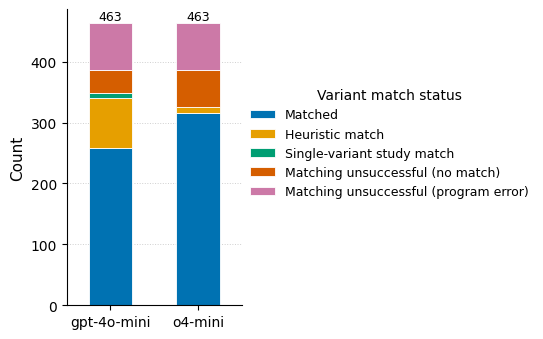

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# -----------------------------
# Inputs assumed to exist:
#   summary_table: index = variant_match_status, columns = model, values = counts
# -----------------------------

# Define desired order and relabel NA
desired_order = [
    "matched",
    "heuristic_matching",
    "single_variant_study_matching",
    "variant_matching_unsuccessful",
    "NA"
]

status_labels = {
    "matched": "Matched",
    "heuristic_matching": "Heuristic match",
    "single_variant_study_match": "Single-variant study match",
    "single_variant_study_matching": "Single-variant study match",
    "variant_matching_unsuccessful": "Matching unsuccessful (no match)",
    "NA": "Matching unsuccessful (program error)"
}

# Safety: ensure NA row exists if you use it as a category
summary_table_plot = summary_table.copy()
if "NA" not in summary_table_plot.index:
    summary_table_plot.loc["NA"] = 0

# Reindex in desired order + relabel
summary_table_plot = summary_table_plot.reindex(desired_order)
summary_table_plot.index = [status_labels.get(x, x) for x in summary_table_plot.index]

# --- Publication-style defaults ---
mpl.rcParams.update({
    "font.family": "DejaVu Sans",   # good default; change if journal requires (e.g., Arial)
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "axes.linewidth": 0.8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "pdf.fonttype": 42,   # TrueType fonts in PDF (better for journals)
    "ps.fonttype": 42,
})

# Colorblind-friendly palette (Okabe-Ito, 5 colors)
status_colors = ["#0072B2", "#E69F00", "#009E73", "#D55E00", "#CC79A7"]

# --- Plot ---
fig, ax = plt.subplots(figsize=(7.2, 3.5))  # reduced height

# Plot stacked bars
(summary_table_plot.T).plot(
    kind="bar",
    stacked=True,
    color=status_colors,
    edgecolor="white",
    linewidth=0.6,
    ax=ax,
)

# Axis labels
ax.set_xlabel("")
ax.set_ylabel("Count")

# Subtle y-grid behind bars
ax.set_axisbelow(True)
ax.yaxis.grid(True, which="major", linestyle=":", linewidth=0.7, alpha=0.6)
ax.xaxis.grid(False)

# Clean spines (keep left/bottom; hide top/right)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Optional: annotate totals above each bar (often useful in rebuttals/papers)
totals = summary_table_plot.sum(axis=0)  # per model
for i, (model, total) in enumerate(totals.items()):
    ax.text(i, total, f"{int(total)}", ha="center", va="bottom", fontsize=9, clip_on=False)

# Legend moved further down
leg = ax.legend(
    title="Variant match status",
    bbox_to_anchor=(1.02, 0.75),
    loc="upper left",
    frameon=False,
    borderaxespad=0.0,
)

# Improve x tick labels
ax.tick_params(axis="x", rotation=0)

# Tight layout with room for legend
fig.tight_layout(rect=[0, 0, 0.78, 1])

# --- Save (vector PDF + 300 dpi raster) ---
out_base = "../res/figures/variant_matching_outcomes_by_model"
fig.savefig(f"{out_base}.pdf", bbox_inches="tight")                 # vector, best for publication
fig.savefig(f"{out_base}.png", dpi=300, bbox_inches="tight")        # 300 dpi raster
# If your journal prefers TIFF:
# fig.savefig(f"{out_base}.tiff", dpi=300, bbox_inches="tight")

plt.show()


In [6]:
res_df_matched = res_df[res_df["variant_match_status"].isin([
    "matched", "heuristic_matching", "single_variant_study_match"
])]
# drop rows where evidence_level_clingen is missing
res_df_matched = res_df_matched[res_df_matched["evidence_level_clingen"].notna()]
res_df_matched

,variant_info,experiments,summary,pmid,model,_error,variant_match_status,variant_match_confidence,variant_match_match_type,variant_match_matched_strings_in_paper,...,variant_match_notes,overall_evidence_evidence_level,overall_evidence_evidence_strength,overall_evidence_odds_path,overall_evidence_validation_basis,overall_evidence_basis,PS3_comments_clingen,BS3_comments_clingen,evidence_level_clingen,evidence_strength_clingen
0,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10286...","{""assay"": ""enzyme activity"", ""authors_conclusi...",The R158W variant in the PAH gene was matched ...,9634518,gpt-4o-mini,NaN,matched,medium,protein,R158Q;;R158W;;R158X,...,R158W is considered a variant of interest due ...,PS3,strong,NaN,Validation based on multiple functional assays...,The R158W variant shows a significant reductio...,2% mutant enzyme activity in BioPKU,NaN,PS3,None
5,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8796...","{""assay"": ""Immunoblot"", ""authors_conclusion"": ...",The P391S variant in the PTEN gene was linked ...,30993208,gpt-4o-mini,NaN,heuristic_matching,medium,heuristic,P391S;;Pro391Ser,...,The variant P391S is mentioned in the context ...,BS3,strong,NaN,Well-established assays with clear controls an...,Functional analysis shows that the P391S varia...,NaN,Missense variants with both lipid phosphatase ...,BS3,None
6,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8796...","{""assay"": ""VAMP-seq"", ""authors_conclusion"": ""p...",The variant p.Pro38Ser in the PTEN gene was ma...,29785012,gpt-4o-mini,NaN,heuristic_matching,medium,protein,p.Pro38Ser,...,Variant matched heuristically through amino ac...,PS3,strong,NaN,Extensive controls were included in the experi...,VAMP-seq data showed that the p.Pro38Ser varia...,NaN,Missense variants with both lipid phosphatase ...,BS3,None
7,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8792...","{""assay"": ""Western blot"", ""authors_conclusion""...",The variant c.209+4_209+7del in PTEN was match...,28677221,gpt-4o-mini,NaN,matched,medium,cdna,c.209+4_209+7del,...,Match found in Table 1 of the paper where c.20...,PS3,strong,NaN,Comparative analysis against normal controls s...,The variant leads to significant changes in pr...,"RNA, mini-gene, or other assay shows impact on...",NaN,PS3,None
8,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8789...","{""assay"": ""Flow cytometry analysis of pAKT"", ""...",The variant p.M35V (rs876659443) applied heuri...,32350270,gpt-4o-mini,NaN,heuristic_matching,medium,heuristic,p.M35V;;p.Met35Val,...,Variant is associated with distinct molecular ...,PS3,strong,NaN,Multiple experimental validations across vario...,The p.M35V variant showed significant function...,Abnormal in vitro cellular assay or transgenic...,NaN,PS3,supporting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,"Gene: MYL3, chr_pos_ref_alt (hg38): chr3_46859...","{""assay"": ""steady-state force-pCa measurement""...",The MYL3 p.Glu143Lys (E143K) variant was direc...,28371863,o4-mini,NaN,matched,medium,protein,E143K;;Glu143Lys;;E143K-ELC,...,NaN,PS3,moderate,NaN,WT normal comparator present; multiple indepen...,Multiple ex vivo and in vitro assays consisten...,"Functional studies, including mouse models pro...",NaN,PS3,supporting
920,"Gene: MYL3, chr_pos_ref_alt (hg38): chr3_46859...","{""assay"": ""Actin-activated ATPase"", ""authors_c...",The TARGET_VARIANT p.E143K in MYL3 is a direct...,29669825,o4-mini,NaN,matched,medium,protein,E143K,...,Exact protein substitution p.E143K described f...,PS3,moderate,NaN,"Quantitative assays with WT comparators, repli...","Multiple independent assays (ATPase, stepping,...","Functional studies, including mouse models pro...",NaN,PS3,supporting
921,"Gene: TNNT2, chr_pos_ref_alt (hg38): chr1_2013...","{""assay"": ""Immunofluorescence sarcomere incorp...",The paper clearly characterizes the TNNT2 c.85...,8958207,o4-mini,NaN,matched,medium,cdna,Int15G1A;;Int15G1A splice site mutation,...,The paper describes the intr

#### PS3/BS3 classification

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def evaluate_by_model_with_abstentions(
    res_df: pd.DataFrame,
    model_col: str = "model",
    y_true_col: str = "evidence_level_clingen",
    y_pred_col: str = "overall_evidence_evidence_level",
    decided_labels=("BS3", "PS3"),
    positive_label="PS3",
) -> dict:
    """
    Evaluate per-model performance when the model makes a decision (decided_labels),
    while treating other outputs (e.g., 'not_clear') as abstentions/missing predictions.

    Returns a dict with:
      - coverage table (per model)
      - metrics table (per model; conditional on decision)
      - confusion matrices (per model)
    """

    # --- checks ---
    required = [model_col, y_true_col, y_pred_col]
    missing = [c for c in required if c not in res_df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df = res_df[required].copy()

    # Keep rows with a ground-truth label (truth should exist); allow pred to be missing/abstain
    df = df.dropna(subset=[model_col, y_true_col])
    if df.empty:
        raise ValueError("No valid rows after dropping missing model/true labels.")

    # --- Coverage: fraction of rows where prediction is one of decided_labels ---
    def _coverage(g: pd.DataFrame) -> float:
        pred = g[y_pred_col]
        return pred.isin(decided_labels).mean()

    coverage_df = (
        df.groupby(model_col, as_index=False)
          .apply(lambda g: pd.Series({
              "n_total": len(g),
              "n_decided": int(g[y_pred_col].isin(decided_labels).sum()),
              "n_abstained_or_missing": int((~g[y_pred_col].isin(decided_labels)).sum()),
              "coverage": _coverage(g),
          }))
          .reset_index()
    )

    # --- Conditional metrics: only where model decided AND truth is in decided_labels ---
    # (truth should be BS3/PS3; if not, those rows are excluded from binary evaluation)
    df_decided = df[df[y_pred_col].isin(decided_labels)].copy()
    df_decided = df_decided[df_decided[y_true_col].isin(decided_labels)].copy()

    if df_decided.empty:
        raise ValueError(
            "No rows remain after filtering to decided predictions and valid binary truth labels."
        )

    # Map decided labels -> {0,1}
    neg_label = [x for x in decided_labels if x != positive_label]
    if len(neg_label) != 1:
        raise ValueError(
            f"Could not infer negative label from decided_labels={decided_labels} "
            f"and positive_label={positive_label}."
        )
    neg_label = neg_label[0]

    label_map = {neg_label: 0, positive_label: 1}
    df_decided["_y_true"] = df_decided[y_true_col].map(label_map)
    df_decided["_y_pred"] = df_decided[y_pred_col].map(label_map)

    # Safety check
    if df_decided[["_y_true", "_y_pred"]].isna().any().any():
        bad_rows = df_decided[df_decided[["_y_true", "_y_pred"]].isna().any(axis=1)]
        raise ValueError(
            "Found unmapped labels after mapping. Sample of problematic rows:\n"
            f"{bad_rows[[model_col, y_true_col, y_pred_col]].head()}"
        )

    results = []
    confusion_matrices = {}

    for model_name, g in df_decided.groupby(model_col):
        y_true = g["_y_true"].to_numpy()
        y_pred = g["_y_pred"].to_numpy()

        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)  # PPV
        rec = recall_score(y_true, y_pred, zero_division=0)      # Sensitivity
        f1 = f1_score(y_true, y_pred, zero_division=0)

        specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
        npv = tn / (tn + fn) if (tn + fn) > 0 else np.nan

        # With hard labels, ROC-AUC/AP are defined but less informative than using probabilities.
        # ROC-AUC also requires both classes present in y_true.
        try:
            roc_auc = roc_auc_score(y_true, y_pred)
        except ValueError:
            roc_auc = np.nan

        try:
            avg_prec = average_precision_score(y_true, y_pred)
        except ValueError:
            avg_prec = np.nan

        results.append({
            "model": model_name,
            "n_decided_used_for_metrics": len(g),
            "accuracy": acc,
            "precision_ppv": prec,
            "recall_sensitivity": rec,
            "f1": f1,
            "specificity_tnr": specificity,
            "npv": npv,
            "roc_auc": roc_auc,
            "average_precision": avg_prec,
            "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        })

        confusion_matrices[model_name] = cm

    metrics_df = pd.DataFrame(results).sort_values("model").reset_index(drop=True)

    # Merge coverage + metrics for convenience (keeps both totals and conditional n)
    report_df = coverage_df.merge(metrics_df, on="model", how="left")

    return {
        "coverage_df": coverage_df,
        "metrics_df": metrics_df,
        "report_df": report_df,
        "confusion_matrices": confusion_matrices,
        "df_decided_used_for_metrics": df_decided,  # helpful for debugging/reproducibility
    }


# -----------------------------
# RUN IT
# -----------------------------
# Choose which DataFrame you want:
#   res_df_matched (as you used) or res_df
out = evaluate_by_model_with_abstentions(
    res_df=res_df_matched,
    model_col="model",
    y_true_col="evidence_level_clingen",
    y_pred_col="overall_evidence_evidence_level",
    decided_labels=("BS3", "PS3"),
    positive_label="PS3",
)

# Main outputs
coverage_df = out["coverage_df"]
metrics_df = out["metrics_df"]
report_df = out["report_df"]
confusion_matrices = out["confusion_matrices"]

print("Coverage (includes abstentions):")
print(coverage_df.to_string(index=False))

print("\nMetrics (conditional on a PS3/BS3 decision):")
print(metrics_df.to_string(index=False))

print("\nCombined report:")
print(report_df.to_string(index=False))

print("\nConfusion matrices (rows=true [0,1], cols=pred [0,1]):")
for model_name, cm in confusion_matrices.items():
    print(f"\n{model_name}")
    print(cm)


Coverage (includes abstentions):
 index       model  n_total  n_decided  n_abstained_or_missing  coverage
     0 gpt-4o-mini    339.0      337.0                     2.0  0.994100
     1     o4-mini    323.0      296.0                    27.0  0.916409

Metrics (conditional on a PS3/BS3 decision):
      model  n_decided_used_for_metrics  accuracy  precision_ppv  recall_sensitivity       f1  specificity_tnr    npv  roc_auc  average_precision  tn  fp  fn  tp
gpt-4o-mini                         337  0.925816       0.931464            0.990066 0.959872         0.371429 0.8125 0.680747           0.931113  13  22   3 299
    o4-mini                         296  0.962838       0.981203            0.977528 0.979362         0.827586 0.8000 0.902557           0.979424  24   5   6 261

Combined report:
 index       model  n_total  n_decided  n_abstained_or_missing  coverage  n_decided_used_for_metrics  accuracy  precision_ppv  recall_sensitivity       f1  specificity_tnr    npv  roc_auc  average_p

/var/folders/df/9mhj2c9d32lf9f0p25vx7l080000gq/T/ipykernel_48628/64537376.py:46: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


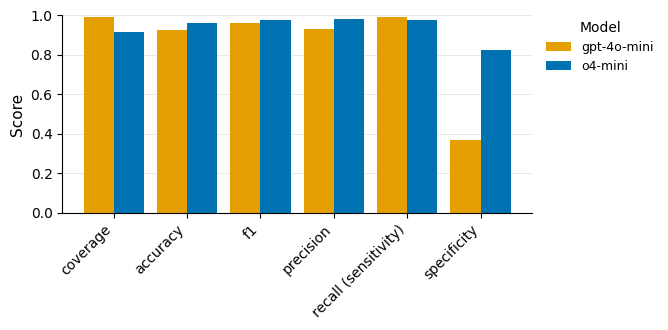

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# -----------------------------
# Plot setup
# -----------------------------
models = list(mat.columns)
metrics = list(mat.index)
n_models = len(models)
n_metrics = len(metrics)

x = np.arange(n_metrics)
group_width = 0.82
bar_width = group_width / max(n_models, 1)
offsets = (np.arange(n_models) - (n_models - 1) / 2) * bar_width

plt.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
})

fig, ax = plt.subplots(figsize=(max(6.8, 1.1 * n_metrics), 3.4))

# -----------------------------
# High-quality, colorblind-safe palette (Okabe–Ito inspired)
# -----------------------------
palette = [
"#E69F00", "#0072B2"
]

if n_models > len(palette):
    raise ValueError("Too many models for the fixed publication palette.")

# -----------------------------
# Bars
# -----------------------------
for i, model in enumerate(models):
    y = mat[model].to_numpy(dtype=float)
    ax.bar(
        x + offsets[i],
        y,
        width=bar_width,
        label=model,
        color=palette[i],
    )

# -----------------------------
# Axes & styling
# -----------------------------
ax.set_xticks(x)
ax.set_xticklabels(
    [metric_label_map[m] for m in metrics],
    rotation=45,
    ha="right"
)

ax.set_ylabel("Score")
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linewidth=0.6, alpha=0.3)
ax.set_axisbelow(True)

# Legend: stacked vertically
ax.legend(
    title="Model",
    frameon=False,
    ncol=1,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.0,
)

fig.tight_layout()

# -----------------------------
# Save
# -----------------------------
fig.savefig("../res/figures/model_ps3_bs3_metrics_barplot.png", dpi=300, bbox_inches="tight")
fig.savefig("../res/figures/model_ps3_bs3_metrics_barplot.pdf", bbox_inches="tight")

plt.show()


#### strength classification

In [17]:
# in res_df_matched, when evidence_strength_clingen is missing put it as strong
res_df_matched["evidence_strength_clingen"] = res_df_matched["evidence_strength_clingen"].fillna("strong")

# in res_df matched, in evidence_strength_clingen, replace Strong with strong, Moderate with moderate,VeryStrong with very_strong, P with supporting, Supporting with supporting
res_df_matched["evidence_strength_clingen"] = res_df_matched["evidence_strength_clingen"].replace({
    "Strong": "strong",
    "Moderate": "moderate",
    "VeryStrong": "very_strong",
    "P": "supporting",
    "Supporting": "supporting"
})
res_df_matched

,variant_info,experiments,summary,pmid,model,_error,variant_match_status,variant_match_confidence,variant_match_match_type,variant_match_matched_strings_in_paper,...,variant_match_notes,overall_evidence_evidence_level,overall_evidence_evidence_strength,overall_evidence_odds_path,overall_evidence_validation_basis,overall_evidence_basis,PS3_comments_clingen,BS3_comments_clingen,evidence_level_clingen,evidence_strength_clingen
0,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10286...","{""assay"": ""enzyme activity"", ""authors_conclusi...",The R158W variant in the PAH gene was matched ...,9634518,gpt-4o-mini,NaN,matched,medium,protein,R158Q;;R158W;;R158X,...,R158W is considered a variant of interest due ...,PS3,strong,NaN,Validation based on multiple functional assays...,The R158W variant shows a significant reductio...,2% mutant enzyme activity in BioPKU,NaN,PS3,strong
5,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8796...","{""assay"": ""Immunoblot"", ""authors_conclusion"": ...",The P391S variant in the PTEN gene was linked ...,30993208,gpt-4o-mini,NaN,heuristic_matching,medium,heuristic,P391S;;Pro391Ser,...,The variant P391S is mentioned in the context ...,BS3,strong,NaN,Well-established assays with clear controls an...,Functional analysis shows that the P391S varia...,NaN,Missense variants with both lipid phosphatase ...,BS3,strong
6,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8796...","{""assay"": ""VAMP-seq"", ""authors_conclusion"": ""p...",The variant p.Pro38Ser in the PTEN gene was ma...,29785012,gpt-4o-mini,NaN,heuristic_matching,medium,protein,p.Pro38Ser,...,Variant matched heuristically through amino ac...,PS3,strong,NaN,Extensive controls were included in the experi...,VAMP-seq data showed that the p.Pro38Ser varia...,NaN,Missense variants with both lipid phosphatase ...,BS3,strong
7,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8792...","{""assay"": ""Western blot"", ""authors_conclusion""...",The variant c.209+4_209+7del in PTEN was match...,28677221,gpt-4o-mini,NaN,matched,medium,cdna,c.209+4_209+7del,...,Match found in Table 1 of the paper where c.20...,PS3,strong,NaN,Comparative analysis against normal controls s...,The variant leads to significant changes in pr...,"RNA, mini-gene, or other assay shows impact on...",NaN,PS3,strong
8,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8789...","{""assay"": ""Flow cytometry analysis of pAKT"", ""...",The variant p.M35V (rs876659443) applied heuri...,32350270,gpt-4o-mini,NaN,heuristic_matching,medium,heuristic,p.M35V;;p.Met35Val,...,Variant is associated with distinct molecular ...,PS3,strong,NaN,Multiple experimental validations across vario...,The p.M35V variant showed significant function...,Abnormal in vitro cellular assay or transgenic...,NaN,PS3,supporting
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,"Gene: MYL3, chr_pos_ref_alt (hg38): chr3_46859...","{""assay"": ""steady-state force-pCa measurement""...",The MYL3 p.Glu143Lys (E143K) variant was direc...,28371863,o4-mini,NaN,matched,medium,protein,E143K;;Glu143Lys;;E143K-ELC,...,NaN,PS3,moderate,NaN,WT normal comparator present; multiple indepen...,Multiple ex vivo and in vitro assays consisten...,"Functional studies, including mouse models pro...",NaN,PS3,supporting
920,"Gene: MYL3, chr_pos_ref_alt (hg38): chr3_46859...","{""assay"": ""Actin-activated ATPase"", ""authors_c...",The TARGET_VARIANT p.E143K in MYL3 is a direct...,29669825,o4-mini,NaN,matched,medium,protein,E143K,...,Exact protein substitution p.E143K described f...,PS3,moderate,NaN,"Quantitative assays with WT comparators, repli...","Multiple independent assays (ATPase, stepping,...","Functional studies, including mouse models pro...",NaN,PS3,supporting
921,"Gene: TNNT2, chr_pos_ref_alt (hg38): chr1_2013...","{""assay"": ""Immunofluorescence sarcomere incorp...",The paper clearly characterizes the TNNT2 c.85...,8958207,o4-mini,NaN,matched,medium,cdna,Int15G1A;;Int15G1A splice site mutation,...,The paper describes 

In [19]:
res_df_matched.evidence_strength_clingen.value_counts()

evidence_strength_clingen
supporting     278
strong         245
moderate       137
very_strong      2
Name: count, dtype: int64

In [20]:
res_df_matched.overall_evidence_evidence_strength.value_counts()

overall_evidence_evidence_strength
strong        298
moderate      220
supporting    115
not_clear      29
Name: count, dtype: int64

In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def evaluate_strength_by_model_with_abstentions(
    res_df: pd.DataFrame,
    model_col: str = "model",
    y_true_col: str = "evidence_strength_clingen",
    y_pred_col: str = "overall_evidence_evidence_strength",
    ordered_levels=("supporting", "moderate", "strong", "very_strong"),
    abstain_label: str = "not_clear",
) -> dict:
    """
    Per-model evaluation for *ordinal* evidence strength with possible abstentions (e.g., 'not_clear').

    What it reports:
      1) Coverage: fraction of rows where the model predicted a valid strength (not abstain/missing).
      2) Multiclass classification metrics on decided rows:
         - Accuracy
         - Precision / Recall / F1 (macro, weighted)
         - Confusion matrix (KxK)
      3) One-vs-rest (OVR) metrics for each class on decided rows:
         - ROC-AUC (OVR for each class, when computable)
         - Average Precision (OVR for each class, when computable)

    Important:
      - ROC-AUC / Average Precision are *best* computed from probabilities. Here we only have hard labels,
        so we compute OVR using one-hot predictions (very strict / less informative). If you later add
        probability columns, swap those in to get more meaningful AUC/AP.
      - Specificity (TNR), PPV, NPV are inherently binary; for multiclass we compute them per class (OVR)
        and also provide macro averages across classes.
    """

    required = [model_col, y_true_col, y_pred_col]
    missing = [c for c in required if c not in res_df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df = res_df[required].copy()
    df = df.dropna(subset=[model_col, y_true_col])  # truth must exist
    if df.empty:
        raise ValueError("No valid rows after dropping missing model/true labels.")

    # Truth must be in ordered_levels (your ground truth includes very_strong; preds may not)
    df = df[df[y_true_col].isin(ordered_levels)].copy()
    if df.empty:
        raise ValueError(f"No rows with truth in ordered_levels={ordered_levels}.")

    # Coverage (decisions are any valid level, i.e., not abstain and in ordered_levels)
    valid_pred_mask = df[y_pred_col].isin(ordered_levels)
    coverage_df = (
        df.groupby(model_col, as_index=False)
          .apply(lambda g: pd.Series({
              "n_total": len(g),
              "n_decided": int(g[y_pred_col].isin(ordered_levels).sum()),
              "n_abstained_or_missing": int((~g[y_pred_col].isin(ordered_levels)).sum()),
              "coverage": float(g[y_pred_col].isin(ordered_levels).mean()),
          }))
          .reset_index()
    )

    # Decided rows for metrics
    df_decided = df[df[y_pred_col].isin(ordered_levels)].copy()
    if df_decided.empty:
        raise ValueError("No decided predictions (all abstained/missing).")

    # Map class labels to ints 0..K-1 in the given order
    level_to_int = {lvl: i for i, lvl in enumerate(ordered_levels)}
    int_to_level = {i: lvl for lvl, i in level_to_int.items()}

    df_decided["_y_true"] = df_decided[y_true_col].map(level_to_int)
    df_decided["_y_pred"] = df_decided[y_pred_col].map(level_to_int)

    if df_decided[["_y_true", "_y_pred"]].isna().any().any():
        bad = df_decided[df_decided[["_y_true", "_y_pred"]].isna().any(axis=1)]
        raise ValueError(
            "Found unmapped labels after mapping. Sample of problematic rows:\n"
            f"{bad[[model_col, y_true_col, y_pred_col]].head()}"
        )

    K = len(ordered_levels)
    labels_int = list(range(K))

    # Helpers for per-class binary metrics (OVR)
    def _safe_div(num, den):
        return num / den if den > 0 else np.nan

    results_rows = []
    confusion_matrices = {}
    per_class_tables = {}

    for model_name, g in df_decided.groupby(model_col):
        y_true = g["_y_true"].to_numpy(dtype=int)
        y_pred = g["_y_pred"].to_numpy(dtype=int)

        # Multiclass confusion matrix
        cm = confusion_matrix(y_true, y_pred, labels=labels_int)
        confusion_matrices[model_name] = cm

        # Multiclass metrics
        acc = accuracy_score(y_true, y_pred)
        prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
        rec_macro  = recall_score(y_true, y_pred, average="macro", zero_division=0)
        f1_macro   = f1_score(y_true, y_pred, average="macro", zero_division=0)

        prec_weighted = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        rec_weighted  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1_weighted   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

        # Per-class (OVR) PPV/NPV/Sensitivity/Specificity + ROC-AUC/AP
        per_class = []
        for c in labels_int:
            y_true_c = (y_true == c).astype(int)
            y_pred_c = (y_pred == c).astype(int)

            cm_c = confusion_matrix(y_true_c, y_pred_c, labels=[0, 1])
            tn, fp, fn, tp = cm_c.ravel()

            ppv = _safe_div(tp, tp + fp)  # precision
            sens = _safe_div(tp, tp + fn) # recall
            spec = _safe_div(tn, tn + fp)
            npv = _safe_div(tn, tn + fn)
            f1c = f1_score(y_true_c, y_pred_c, zero_division=0)

            # AUC/AP with hard predictions (one-hot); only computable if both classes present
            try:
                auc = roc_auc_score(y_true_c, y_pred_c)
            except ValueError:
                auc = np.nan

            try:
                ap = average_precision_score(y_true_c, y_pred_c)
            except ValueError:
                ap = np.nan

            per_class.append({
                "class": int_to_level[c],
                "tp": tp, "fp": fp, "fn": fn, "tn": tn,
                "precision_ppv": ppv,
                "recall_sensitivity": sens,
                "specificity_tnr": spec,
                "npv": npv,
                "f1": f1c,
                "roc_auc_ovr": auc,
                "average_precision_ovr": ap,
                "support": int((y_true == c).sum()),
            })

        per_class_df = pd.DataFrame(per_class)

        # Macro averages over classes for the binary-style metrics
        ppv_macro = per_class_df["precision_ppv"].mean(skipna=True)
        sens_macro = per_class_df["recall_sensitivity"].mean(skipna=True)
        spec_macro = per_class_df["specificity_tnr"].mean(skipna=True)
        npv_macro = per_class_df["npv"].mean(skipna=True)
        auc_macro = per_class_df["roc_auc_ovr"].mean(skipna=True)
        ap_macro = per_class_df["average_precision_ovr"].mean(skipna=True)

        results_rows.append({
            "model": model_name,
            "n_decided_used_for_metrics": len(g),
            "accuracy": acc,
            "precision_macro": prec_macro,
            "recall_macro": rec_macro,
            "f1_macro": f1_macro,
            "precision_weighted": prec_weighted,
            "recall_weighted": rec_weighted,
            "f1_weighted": f1_weighted,
            # macro over OVR binary-style metrics:
            "ppv_macro_ovr": ppv_macro,
            "sensitivity_macro_ovr": sens_macro,
            "specificity_macro_ovr": spec_macro,
            "npv_macro_ovr": npv_macro,
            "roc_auc_macro_ovr": auc_macro,
            "avg_precision_macro_ovr": ap_macro,
        })

        per_class_tables[model_name] = per_class_df

    metrics_df = pd.DataFrame(results_rows).sort_values("model").reset_index(drop=True)
    report_df = coverage_df.merge(metrics_df, on="model", how="left")

    return {
        "coverage_df": coverage_df,                 # includes abstentions
        "metrics_df": metrics_df,                   # decided-only multiclass metrics
        "report_df": report_df,                     # merged coverage + metrics
        "confusion_matrices": confusion_matrices,   # KxK per model
        "per_class_tables": per_class_tables,       # OVR per-class metrics per model
        "df_decided_used_for_metrics": df_decided,  # reproducibility/debugging
        "ordered_levels": ordered_levels,
    }


# -----------------------------
# RUN IT
# -----------------------------
out_strength = evaluate_strength_by_model_with_abstentions(
    res_df=res_df_matched,  # or res_df
    model_col="model",
    y_true_col="evidence_strength_clingen",
    y_pred_col="overall_evidence_evidence_strength",
    ordered_levels=("supporting", "moderate", "strong", "very_strong"),
    abstain_label="not_clear",
)

print("Coverage (includes abstentions):")
print(out_strength["coverage_df"].to_string(index=False))

print("\nMetrics (conditional on a strength decision):")
print(out_strength["metrics_df"].to_string(index=False))

print("\nCombined report:")
print(out_strength["report_df"].to_string(index=False))

print("\nConfusion matrices (rows=true, cols=pred) in order:", out_strength["ordered_levels"])
for m, cm in out_strength["confusion_matrices"].items():
    print(f"\n{m}")
    print(cm)

print("\nPer-class OVR tables:")
for m, t in out_strength["per_class_tables"].items():
    print(f"\n{m}")
    print(t.to_string(index=False))


Coverage (includes abstentions):
 index       model  n_total  n_decided  n_abstained_or_missing  coverage
     0 gpt-4o-mini    339.0      337.0                     2.0  0.994100
     1     o4-mini    323.0      296.0                    27.0  0.916409

Metrics (conditional on a strength decision):
      model  n_decided_used_for_metrics  accuracy  precision_macro  recall_macro  f1_macro  precision_weighted  recall_weighted  f1_weighted  ppv_macro_ovr  sensitivity_macro_ovr  specificity_macro_ovr  npv_macro_ovr  roc_auc_macro_ovr  avg_precision_macro_ovr
gpt-4o-mini                         337  0.359050         0.236294      0.255476  0.176610            0.327470         0.359050     0.236194       0.315058               0.255476               0.752046       0.758011           0.503761                 0.251588
    o4-mini                         296  0.337838         0.431834      0.280245  0.211506            0.611412         0.337838     0.287042       0.575778               0.280245 

/var/folders/df/9mhj2c9d32lf9f0p25vx7l080000gq/T/ipykernel_48628/525173635.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


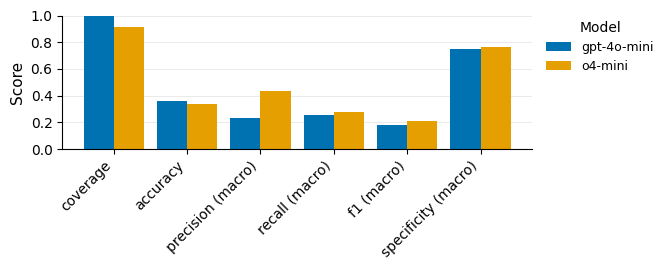

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# -----------------------------
# Build matrix (metrics x models) from out_strength
# -----------------------------
report_df = out_strength["report_df"].copy()

# Choose which metrics to plot (edit this list as you like)
metrics_to_plot = [
    "coverage",
    "accuracy",
    "precision_macro",
    "recall_macro",
    "f1_macro",
    "specificity_macro_ovr",
    #"npv_macro_ovr",
    # Optional (often less informative with hard labels; include if you want)
    # "roc_auc_macro_ovr",
    # "avg_precision_macro_ovr",
]

# Pretty labels for x-axis
metric_label_map = {
    "coverage": "coverage",
    "accuracy": "accuracy",
    "precision_macro": "precision (macro)",
    "recall_macro": "recall (macro)",
    "f1_macro": "f1 (macro)",
    "precision_weighted": "Precision (weighted)",
    "recall_weighted": "Recall (weighted)",
    "f1_weighted": "F1 (weighted)",
    "ppv_macro_ovr": "PPV (macro, OVR)",
    "sensitivity_macro_ovr": "Sensitivity (macro, OVR)",
    "specificity_macro_ovr": "specificity (macro)",
    "npv_macro_ovr": "NPV (macro, OVR)",
    "roc_auc_macro_ovr": "ROC-AUC (macro, OVR)",
    "avg_precision_macro_ovr": "Avg Precision (macro, OVR)",
}

# Make a metrics x models matrix (like your previous `mat`)
mat = (
    report_df.set_index("model")[metrics_to_plot]
             .T
)

# Ensure all requested labels exist
missing_labels = [m for m in mat.index if m not in metric_label_map]
if missing_labels:
    # fall back to raw names for any missing pretty labels
    for m in missing_labels:
        metric_label_map[m] = m

# -----------------------------
# Plot setup
# -----------------------------
models = list(mat.columns)
metrics = list(mat.index)
n_models = len(models)
n_metrics = len(metrics)

x = np.arange(n_metrics)
group_width = 0.82
bar_width = group_width / max(n_models, 1)
offsets = (np.arange(n_models) - (n_models - 1) / 2) * bar_width

plt.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
})

# Smaller height, similar to what you wanted earlier
fig, ax = plt.subplots(figsize=(max(6.8, 1.1 * n_metrics), 2.8))

# -----------------------------
# Publication-friendly palette (Okabe–Ito + extensions)
# (still colorblind-safe; supports more models)
# -----------------------------
palette = [
    "#0072B2",  # blue
    "#E69F00",  # orange
    "#009E73",  # green
    "#D55E00",  # vermillion
    "#CC79A7",  # purple
    "#56B4E9",  # sky blue
    "#F0E442",  # yellow
    "#000000",  # black
]

if n_models > len(palette):
    raise ValueError(
        f"Too many models ({n_models}) for the fixed publication palette ({len(palette)}). "
        "Extend `palette` or generate a colormap."
    )

# -----------------------------
# Bars
# -----------------------------
for i, model in enumerate(models):
    y = mat[model].to_numpy(dtype=float)
    ax.bar(
        x + offsets[i],
        y,
        width=bar_width,
        label=model,
        color=palette[i],
    )

# -----------------------------
# Axes & styling
# -----------------------------
ax.set_xticks(x)
ax.set_xticklabels([metric_label_map[m] for m in metrics], rotation=45, ha="right")

ax.set_ylabel("Score")
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linewidth=0.6, alpha=0.3)
ax.set_axisbelow(True)

# Legend: stacked vertically
ax.legend(
    title="Model",
    frameon=False,
    ncol=1,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.0,
)

fig.tight_layout()

# -----------------------------
# Save
# -----------------------------
fig.savefig("../res/figures/model_strength_metrics_barplot.png", dpi=300, bbox_inches="tight")
fig.savefig("../res/figures/model_strength_metrics_barplot.pdf", bbox_inches="tight")

plt.show()


#### both PS3/BS3 and strength

In [36]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def evaluate_joint_level_strength_by_model_with_abstentions(
    res_df: pd.DataFrame,
    model_col: str = "model",
    # truth
    y_true_level_col: str = "evidence_level_clingen",
    y_true_strength_col: str = "evidence_strength_clingen",
    # preds
    y_pred_level_col: str = "overall_evidence_evidence_level",
    y_pred_strength_col: str = "overall_evidence_evidence_strength",
    # allowed sets
    decided_levels=("BS3", "PS3"),
    ordered_strengths=("supporting", "moderate", "strong", "very_strong"),
    # abstain labels
    abstain_labels=("not_clear",),
) -> dict:
    """
    Joint evaluation of (level, strength) as a *multiclass* problem, e.g.:
      PS3_strong, BS3_moderate, ...

    Abstention / missing predictions:
      - If either predicted level is not in decided_levels OR predicted strength is not in ordered_strengths
        (including 'not_clear'/NaN), the joint prediction is treated as abstained.

    Metrics are computed on decided rows only, where:
      - truth level in decided_levels
      - truth strength in ordered_strengths
      - pred level in decided_levels
      - pred strength in ordered_strengths

    Returns:
      - coverage_df (per model)
      - metrics_df (per model; decided-only multiclass)
      - report_df (merged)
      - confusion_matrices (per model; KxK)
      - per_class_tables (OVR per class; per model)
      - df_decided_used_for_metrics (rows used)
      - joint_classes (class order used for confusion matrices)
    """

    required = [
        model_col,
        y_true_level_col, y_true_strength_col,
        y_pred_level_col, y_pred_strength_col
    ]
    missing = [c for c in required if c not in res_df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df = res_df[required].copy()

    # truth must exist (both dimensions)
    df = df.dropna(subset=[model_col, y_true_level_col, y_true_strength_col])
    if df.empty:
        raise ValueError("No valid rows after dropping missing model/true labels.")

    # keep only valid truth labels
    df = df[
        df[y_true_level_col].isin(decided_levels) &
        df[y_true_strength_col].isin(ordered_strengths)
    ].copy()
    if df.empty:
        raise ValueError(
            f"No rows with truth in decided_levels={decided_levels} "
            f"and ordered_strengths={ordered_strengths}."
        )

    # define the full joint label space (cartesian product) in a stable order
    joint_classes = [f"{lvl}_{strg}" for lvl in decided_levels for strg in ordered_strengths]
    joint_to_int = {lab: i for i, lab in enumerate(joint_classes)}
    int_to_joint = {i: lab for lab, i in joint_to_int.items()}
    K = len(joint_classes)
    labels_int = list(range(K))

    def _make_joint(level_series: pd.Series, strength_series: pd.Series) -> pd.Series:
        # If either is missing, result will be NaN -> treated as abstain
        return level_series.astype("string") + "_" + strength_series.astype("string")

    # predicted is "decided" only if BOTH components are valid
    pred_level_valid = df[y_pred_level_col].isin(decided_levels)
    pred_strength_valid = df[y_pred_strength_col].isin(ordered_strengths)

    # also treat explicit abstain labels as not valid (defensive; usually covered by isin checks)
    for ab in abstain_labels:
        if ab is not None:
            pred_level_valid &= (df[y_pred_level_col] != ab)
            pred_strength_valid &= (df[y_pred_strength_col] != ab)

    pred_joint_decided_mask = pred_level_valid & pred_strength_valid

    # --- coverage ---
    coverage_df = (
        df.groupby(model_col, as_index=False)
          .apply(lambda g: pd.Series({
              "n_total": int(len(g)),
              "n_decided": int((g[y_pred_level_col].isin(decided_levels) & g[y_pred_strength_col].isin(ordered_strengths)).sum()),
              "n_abstained_or_missing": int((~(g[y_pred_level_col].isin(decided_levels) & g[y_pred_strength_col].isin(ordered_strengths))).sum()),
              "coverage": float((g[y_pred_level_col].isin(decided_levels) & g[y_pred_strength_col].isin(ordered_strengths)).mean()),
          }))
          .reset_index()
    )

    # --- decided rows for metrics ---
    df_decided = df[pred_joint_decided_mask].copy()
    if df_decided.empty:
        raise ValueError("No decided predictions (all abstained/missing on level and/or strength).")

    df_decided["_true_joint"] = _make_joint(df_decided[y_true_level_col], df_decided[y_true_strength_col])
    df_decided["_pred_joint"] = _make_joint(df_decided[y_pred_level_col], df_decided[y_pred_strength_col])

    # map to ints (guaranteed in joint_classes if truth/pred components were validated)
    df_decided["_y_true"] = df_decided["_true_joint"].map(joint_to_int)
    df_decided["_y_pred"] = df_decided["_pred_joint"].map(joint_to_int)

    if df_decided[["_y_true", "_y_pred"]].isna().any().any():
        bad = df_decided[df_decided[["_y_true", "_y_pred"]].isna().any(axis=1)]
        raise ValueError(
            "Found unmapped joint labels after mapping. Sample of problematic rows:\n"
            f"{bad[[model_col, y_true_level_col, y_true_strength_col, y_pred_level_col, y_pred_strength_col, '_true_joint', '_pred_joint']].head()}"
        )

    def _safe_div(num, den):
        return num / den if den > 0 else np.nan

    results_rows = []
    confusion_matrices = {}
    per_class_tables = {}

    for model_name, g in df_decided.groupby(model_col):
        y_true = g["_y_true"].to_numpy(dtype=int)
        y_pred = g["_y_pred"].to_numpy(dtype=int)

        cm = confusion_matrix(y_true, y_pred, labels=labels_int)
        confusion_matrices[model_name] = cm

        # multiclass metrics
        acc = accuracy_score(y_true, y_pred)
        prec_macro = precision_score(y_true, y_pred, average="macro", zero_division=0)
        rec_macro  = recall_score(y_true, y_pred, average="macro", zero_division=0)
        f1_macro   = f1_score(y_true, y_pred, average="macro", zero_division=0)

        prec_weighted = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        rec_weighted  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1_weighted   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

        # per-class OVR table (binary-style metrics + AUC/AP on hard labels)
        per_class = []
        for c in labels_int:
            y_true_c = (y_true == c).astype(int)
            y_pred_c = (y_pred == c).astype(int)

            cm_c = confusion_matrix(y_true_c, y_pred_c, labels=[0, 1])
            tn, fp, fn, tp = cm_c.ravel()

            ppv  = _safe_div(tp, tp + fp)
            sens = _safe_div(tp, tp + fn)
            spec = _safe_div(tn, tn + fp)
            npv  = _safe_div(tn, tn + fn)
            f1c  = f1_score(y_true_c, y_pred_c, zero_division=0)

            try:
                auc = roc_auc_score(y_true_c, y_pred_c)
            except ValueError:
                auc = np.nan

            try:
                ap = average_precision_score(y_true_c, y_pred_c)
            except ValueError:
                ap = np.nan

            per_class.append({
                "class": int_to_joint[c],
                "support": int(y_true_c.sum()),
                "tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn),
                "precision_ppv": ppv,
                "recall_sensitivity": sens,
                "specificity_tnr": spec,
                "npv": npv,
                "f1": f1c,
                "roc_auc_ovr": auc,
                "average_precision_ovr": ap,
            })

        per_class_df = pd.DataFrame(per_class)

        results_rows.append({
            "model": model_name,
            "n_decided_used_for_metrics": int(len(g)),
            "accuracy": acc,
            "precision_macro": prec_macro,
            "recall_macro": rec_macro,
            "f1_macro": f1_macro,
            "precision_weighted": prec_weighted,
            "recall_weighted": rec_weighted,
            "f1_weighted": f1_weighted,
            # macro over OVR binary-style metrics:
            "ppv_macro_ovr": per_class_df["precision_ppv"].mean(skipna=True),
            "sensitivity_macro_ovr": per_class_df["recall_sensitivity"].mean(skipna=True),
            "specificity_macro_ovr": per_class_df["specificity_tnr"].mean(skipna=True),
            "npv_macro_ovr": per_class_df["npv"].mean(skipna=True),
            "roc_auc_macro_ovr": per_class_df["roc_auc_ovr"].mean(skipna=True),
            "avg_precision_macro_ovr": per_class_df["average_precision_ovr"].mean(skipna=True),
        })

        per_class_tables[model_name] = per_class_df

    metrics_df = pd.DataFrame(results_rows).sort_values("model").reset_index(drop=True)
    report_df = coverage_df.merge(metrics_df, on="model", how="left")

    return {
        "coverage_df": coverage_df,
        "metrics_df": metrics_df,
        "report_df": report_df,
        "confusion_matrices": confusion_matrices,
        "per_class_tables": per_class_tables,
        "df_decided_used_for_metrics": df_decided,
        "joint_classes": joint_classes,
    }


# -----------------------------
# RUN IT
# -----------------------------
out_joint = evaluate_joint_level_strength_by_model_with_abstentions(
    res_df=res_df_matched,
    model_col="model",
    y_true_level_col="evidence_level_clingen",
    y_true_strength_col="evidence_strength_clingen",
    y_pred_level_col="overall_evidence_evidence_level",
    y_pred_strength_col="overall_evidence_evidence_strength",
    decided_levels=("BS3", "PS3"),
    ordered_strengths=("supporting", "moderate", "strong", "very_strong"),
    abstain_labels=("not_clear",),
)

print("Coverage (includes abstentions):")
print(out_joint["coverage_df"].to_string(index=False))

print("\nMetrics (conditional on joint decision):")
print(out_joint["metrics_df"].to_string(index=False))

print("\nCombined report:")
print(out_joint["report_df"].to_string(index=False))

print("\nConfusion matrices (rows=true, cols=pred) in order:")
print(out_joint["joint_classes"])
for m, cm in out_joint["confusion_matrices"].items():
    print(f"\n{m}")
    print(cm)

print("\nPer-class OVR tables:")
for m, t in out_joint["per_class_tables"].items():
    print(f"\n{m}")
    print(t.to_string(index=False))


Coverage (includes abstentions):
 index       model  n_total  n_decided  n_abstained_or_missing  coverage
     0 gpt-4o-mini    339.0      337.0                     2.0  0.994100
     1     o4-mini    323.0      296.0                    27.0  0.916409

Metrics (conditional on joint decision):
      model  n_decided_used_for_metrics  accuracy  precision_macro  recall_macro  f1_macro  precision_weighted  recall_weighted  f1_weighted  ppv_macro_ovr  sensitivity_macro_ovr  specificity_macro_ovr  npv_macro_ovr  roc_auc_macro_ovr  avg_precision_macro_ovr
gpt-4o-mini                         337  0.335312         0.206843      0.194696  0.147253            0.360142         0.335312     0.219161       0.241317               0.194696               0.880779       0.890897           0.529222                 0.141146
    o4-mini                         296  0.320946         0.318057      0.291539  0.202152            0.562337         0.320946     0.271799       0.445280               0.291539      

/var/folders/df/9mhj2c9d32lf9f0p25vx7l080000gq/T/ipykernel_48628/597325021.py:100: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({
/opt/anaconda3/envs/ps3_bs3_llm/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/ps3_bs3_llm/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/opt/anaconda3/envs/ps3_bs3_llm/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is 

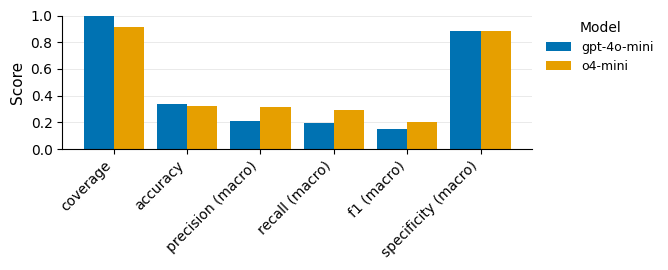

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# -----------------------------
# Build matrix (metrics x models) from out_joint
# -----------------------------
report_df = out_joint["report_df"].copy()

# Choose which metrics to plot (edit this list as you like)
metrics_to_plot = [
    "coverage",
    "accuracy",
    "precision_macro",
    "recall_macro",
    "f1_macro",
    "specificity_macro_ovr",
    # optional
    # "ppv_macro_ovr",
    # "sensitivity_macro_ovr",
    # "npv_macro_ovr",
    # "roc_auc_macro_ovr",
    # "avg_precision_macro_ovr",
]

# Pretty labels for x-axis
metric_label_map = {
    "coverage": "coverage",
    "accuracy": "accuracy",
    "precision_macro": "precision (macro)",
    "recall_macro": "recall (macro)",
    "f1_macro": "f1 (macro)",
    "precision_weighted": "precision (weighted)",
    "recall_weighted": "recall (weighted)",
    "f1_weighted": "f1 (weighted)",
    "ppv_macro_ovr": "PPV (macro, OVR)",
    "sensitivity_macro_ovr": "Sensitivity (macro, OVR)",
    "specificity_macro_ovr": "specificity (macro)",
    "npv_macro_ovr": "NPV (macro, OVR)",
    "roc_auc_macro_ovr": "ROC-AUC (macro, OVR)",
    "avg_precision_macro_ovr": "Avg Precision (macro, OVR)",
}

# Make a metrics x models matrix (like your previous `mat`)
mat = report_df.set_index("model")[metrics_to_plot].T

# Ensure all requested labels exist
missing_labels = [m for m in mat.index if m not in metric_label_map]
for m in missing_labels:
    metric_label_map[m] = m

# -----------------------------
# Plot setup
# -----------------------------
models = list(mat.columns)
metrics = list(mat.index)
n_models = len(models)
n_metrics = len(metrics)

x = np.arange(n_metrics)
group_width = 0.82
bar_width = group_width / max(n_models, 1)
offsets = (np.arange(n_models) - (n_models - 1) / 2) * bar_width

plt.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 10,
    "axes.labelsize": 11,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
})

# Smaller height (publication-ish)
fig, ax = plt.subplots(figsize=(max(6.8, 1.1 * n_metrics), 2.8))

# -----------------------------
# Publication-friendly palette (Okabe–Ito + extensions)
# -----------------------------
palette = [
    "#0072B2",  # blue
    "#E69F00",  # orange
    "#009E73",  # green
    "#D55E00",  # vermillion
    "#CC79A7",  # purple
    "#56B4E9",  # sky blue
    "#F0E442",  # yellow
    "#000000",  # black
]

if n_models > len(palette):
    raise ValueError(
        f"Too many models ({n_models}) for the fixed publication palette ({len(palette)}). "
        "Extend `palette` or switch to a colormap."
    )

# -----------------------------
# Bars
# -----------------------------
for i, model in enumerate(models):
    y = mat[model].to_numpy(dtype=float)
    ax.bar(
        x + offsets[i],
        y,
        width=bar_width,
        label=model,
        color=palette[i],
    )

# -----------------------------
# Axes & styling
# -----------------------------
ax.set_xticks(x)
ax.set_xticklabels([metric_label_map[m] for m in metrics], rotation=45, ha="right")

ax.set_ylabel("Score")
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(MaxNLocator(nbins=6))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linewidth=0.6, alpha=0.3)
ax.set_axisbelow(True)

# Legend: stacked vertically
ax.legend(
    title="Model",
    frameon=False,
    ncol=1,
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.0,
)

fig.tight_layout()

# -----------------------------
# Save (rename files to joint)
# -----------------------------
fig.savefig("../res/figures/model_joint_metrics_barplot.png", dpi=300, bbox_inches="tight")
fig.savefig("../res/figures/model_joint_metrics_barplot.pdf", bbox_inches="tight")

plt.show()


#### LLM as a judge

In [191]:
import os
import json
import re
import random
from typing import Any, Dict, List, Optional

import pandas as pd
from openai import OpenAI
from tqdm import tqdm

# ------------------------------------------------------------
# OpenAI client
# ------------------------------------------------------------
client = OpenAI()

# ------------------------------------------------------------
# Configuration
# ------------------------------------------------------------
PDF_DIR = "../res/pdfs/"  # kept for compatibility; PDF judging is disabled below
JUDGE_MODEL = "gpt-4.1"

GEN_COLS = [
    "experiments",
    "summary",
    "overall_evidence_validation_basis",
    "overall_evidence_basis",
]

# ------------------------------------------------------------
# Utilities
# ------------------------------------------------------------
def _clean(x: Any) -> str:
    if x is None:
        return ""
    if isinstance(x, float) and pd.isna(x):
        return ""
    return re.sub(r"\s+", " ", str(x)).strip()


def extract_response_text(resp) -> str:
    """
    Correct extractor for OpenAI Responses API objects.
    """
    chunks = []
    for item in resp.output:
        if hasattr(item, "content"):
            for c in item.content:
                if getattr(c, "type", None) == "output_text":
                    chunks.append(c.text)
    return "\n".join(chunks).strip()


def _extract_first_json(text: str) -> Dict[str, Any]:
    """
    Extract the first JSON object from a text blob.
    Raises if not found or not valid JSON.
    """
    if "{" not in text:
        raise ValueError(f"Non-JSON output: {text[:200]}")
    m = re.search(r"\{.*\}", text, re.S)
    if not m:
        raise ValueError(f"Could not locate JSON object in: {text[:200]}")
    return json.loads(m.group(0))


def _stable_seed(*parts: str) -> int:
    """
    Stable (process-independent) seed from input strings.
    Avoid Python's built-in hash() randomness.
    """
    s = "||".join(parts)
    # simple stable hash
    h = 2166136261
    for ch in s:
        h ^= ord(ch)
        h = (h * 16777619) & 0xFFFFFFFF
    return int(h)


# ------------------------------------------------------------
# Text assembly
# ------------------------------------------------------------
def build_generated_summary(row: pd.Series) -> str:
    parts = []
    for c in GEN_COLS:
        txt = _clean(row.get(c))
        if txt:
            parts.append(f"{c}: {txt}")
    return "\n".join(parts)


def build_clingen_summary(row: pd.Series) -> str:
    lvl = _clean(row.get("evidence_level_clingen"))
    if lvl == "PS3":
        return _clean(row.get("PS3_comments_clingen"))
    if lvl == "BS3":
        return _clean(row.get("BS3_comments_clingen"))
    return ""


# ------------------------------------------------------------
# Prompt (improved; inspired by CGBench judge prompt + robustness)
#   - uses A/B formatting to reduce position bias
#   - explicit content-over-wording instruction
#   - compatible with majority-vote sampling
# ------------------------------------------------------------
PROMPT_COVERAGE_AB = """
You are an impartial scientific judge. Your task is to rigorously determine how well two explanations
refer to the same underlying evidence/experiment and make compatible conclusions about it.

Focus on CONTENT, not wording:
- One explanation may be much more terse than the other.
- Extra correct detail is OK and should not be penalized.
- Penalize contradictions, different experiments, or meaningfully different conclusions.

Avoid position bias: do not prefer A or B due to order.

Score correspondence on a 1–5 Likert scale:
1 = Not the same evidence / contradicts / mostly unrelated
2 = Some overlap but key evidence/conclusions differ or many important misses
3 = Same general evidence but incomplete, vague, or partially mismatched
4 = Same evidence and compatible conclusions; minor omissions OK
5 = Same evidence and conclusions; highly consistent; extra correct detail OK

Return JSON ONLY with:
- score (integer 1–5)
- confidence (0–100)
- rationale (<= 40 words; cite the key reason: same experiment? contradiction? missing key result?)

Explanation A:
{A}

Explanation B:
{B}
""".strip()


# ------------------------------------------------------------
# Single-call judge (returns one score)
# ------------------------------------------------------------
def _judge_once_coverage_ab(
    A: str,
    B: str,
    temperature: float = 1.0,
) -> Dict[str, Any]:
    try:
        resp = client.responses.create(
            model=JUDGE_MODEL,
            temperature=temperature,
            input=[
                {"role": "system", "content": "You are a careful, unbiased scientific reviewer."},
                {"role": "user", "content": PROMPT_COVERAGE_AB.format(A=A, B=B)},
            ],
        )

        text = extract_response_text(resp)
        obj = _extract_first_json(text)

        score = int(obj["score"])
        if score < 1 or score > 5:
            raise ValueError("Score out of range")

        conf = obj.get("confidence")
        try:
            conf = None if conf is None else int(conf)
        except Exception:
            pass

        rat = obj.get("rationale")
        rat = None if rat is None else str(rat).strip()

        return {
            "score": score,
            "confidence": conf,
            "rationale": rat,
            "error": None,
        }

    except Exception as e:
        return {
            "score": None,
            "confidence": None,
            "rationale": None,
            "error": str(e),
        }


# ------------------------------------------------------------
# Majority voting (5 times) + position-bias adjustment (swap A/B)
#   Inspired by CGBench: majority vote with positional bias mitigation.
#   Here: do n_votes samples, and for each sample also query swapped order,
#   then aggregate all valid scores by majority vote (ties -> median -> closest-to-median).
# ------------------------------------------------------------
def judge_vs_clingen_coverage_majority(
    generated: str,
    curated: str,
    n_votes: int = 5,
    temperature: float = 1.0,
    do_position_swap: bool = True,
) -> Dict[str, Any]:
    if not generated or not curated:
        return {
            "score": None,
            "confidence": None,
            "rationale": None,
            "error": "missing text",
            "votes": [],
            "vote_scores": [],
            "vote_confidences": [],
            "vote_errors": [],
        }

    rng = random.Random(_stable_seed(generated, curated, str(n_votes), str(do_position_swap)))

    votes: List[Dict[str, Any]] = []
    # deterministic but “shuffled” order across runs
    order_flags = [True] * n_votes
    rng.shuffle(order_flags)

    for flag in order_flags:
        # flag=True: A=curated, B=generated; flag=False: A=generated, B=curated
        if flag:
            A, B = curated, generated
        else:
            A, B = generated, curated

        votes.append(_judge_once_coverage_ab(A=A, B=B, temperature=temperature))

        if do_position_swap:
            votes.append(_judge_once_coverage_ab(A=B, B=A, temperature=temperature))

    valid = [v for v in votes if v.get("score") is not None and v.get("error") is None]
    if not valid:
        # fall back: report first error (if any)
        first_err = next((v.get("error") for v in votes if v.get("error")), "all votes failed")
        return {
            "score": None,
            "confidence": None,
            "rationale": None,
            "error": first_err,
            "votes": votes,
            "vote_scores": [v.get("score") for v in votes],
            "vote_confidences": [v.get("confidence") for v in votes],
            "vote_errors": [v.get("error") for v in votes],
        }

    scores = [int(v["score"]) for v in valid]
    # majority vote
    counts: Dict[int, int] = {}
    for s in scores:
        counts[s] = counts.get(s, 0) + 1
    max_ct = max(counts.values())
    modes = sorted([s for s, ct in counts.items() if ct == max_ct])

    if len(modes) == 1:
        final_score = modes[0]
    else:
        # tie-break: median then closest-to-median
        sorted_scores = sorted(scores)
        mid = len(sorted_scores) // 2
        median = sorted_scores[mid] if (len(sorted_scores) % 2 == 1) else int(round((sorted_scores[mid - 1] + sorted_scores[mid]) / 2))
        # pick tied mode closest to median; if still tie pick smaller (more conservative)
        final_score = sorted(modes, key=lambda s: (abs(s - median), s))[0]

    # choose a representative rationale: among votes with final_score, pick highest confidence
    same_score = [v for v in valid if int(v["score"]) == int(final_score)]
    def _conf(v: Dict[str, Any]) -> int:
        c = v.get("confidence")
        return -1 if c is None else int(c)

    best = max(same_score, key=_conf) if same_score else max(valid, key=_conf)

    # aggregate confidence: median of confidences (robust)
    confs = sorted([_conf(v) for v in valid if _conf(v) >= 0])
    final_conf = None
    if confs:
        mid = len(confs) // 2
        final_conf = confs[mid] if (len(confs) % 2 == 1) else int(round((confs[mid - 1] + confs[mid]) / 2))

    return {
        "score": int(final_score),
        "confidence": final_conf,
        "rationale": best.get("rationale"),
        "error": None,
        "votes": votes,
        "vote_scores": [v.get("score") for v in votes],
        "vote_confidences": [v.get("confidence") for v in votes],
        "vote_errors": [v.get("error") for v in votes],
        "vote_counts": counts,
    }


# ------------------------------------------------------------
# Main  pipeline
#   - ONLY ClinGen coverage
#   - majority voting @5 with positional-swap mitigation
#   - returns ONLY row-level df
# ------------------------------------------------------------
def llm_judge_scores_clingen_coverage_voting(
    in_df: pd.DataFrame,
    n_votes: int = 3,
    temperature: float = 1.0,
    do_position_swap: bool = True,
    keep_vote_details: bool = True,
) -> pd.DataFrame:
    df = in_df.copy()

    df["_gen_text"] = df.apply(build_generated_summary, axis=1)
    df["_clingen_text"] = df.apply(build_clingen_summary, axis=1)

    cov_results = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Judging ClinGen coverage (majority vote)"):
        cov_results.append(
            judge_vs_clingen_coverage_majority(
                generated=row["_gen_text"],
                curated=row["_clingen_text"],
                n_votes=n_votes,
                temperature=temperature,
                do_position_swap=do_position_swap,
            )
        )

    df["_coverage_score"] = [r.get("score") for r in cov_results]
    df["_coverage_confidence"] = [r.get("confidence") for r in cov_results]
    df["_coverage_rationale"] = [r.get("rationale") for r in cov_results]
    df["_coverage_error"] = [r.get("error") for r in cov_results]

    if keep_vote_details:
        df["_coverage_vote_scores"] = [r.get("vote_scores") for r in cov_results]
        df["_coverage_vote_confidences"] = [r.get("vote_confidences") for r in cov_results]
        df["_coverage_vote_errors"] = [r.get("vote_errors") for r in cov_results]
        df["_coverage_vote_counts"] = [r.get("vote_counts") for r in cov_results]

    return df


In [192]:
res_df_matched_llmJudgeScored = llm_judge_scores_clingen_coverage_voting(res_df_matched)

Judging ClinGen coverage (majority vote): 100%|██████████| 662/662 [2:49:45<00:00, 15.39s/it]  


In [193]:
res_df_matched_llmJudgeScored.to_csv("../data/ps3_bs3_df_processed_withVariantIDs_llmClassifier_llmJudgeScored.csv", index=False)

In [1]:
import pandas as pd
res_df_matched_llmJudgeScored  = pd.read_csv("../data/ps3_bs3_df_processed_withVariantIDs_llmClassifier_llmJudgeScored.csv")
res_df_matched_llmJudgeScored

,variant_info,experiments,summary,pmid,model,_error,variant_match_status,variant_match_confidence,variant_match_match_type,variant_match_matched_strings_in_paper,...,_gen_text,_clingen_text,_coverage_score,_coverage_confidence,_coverage_rationale,_coverage_error,_coverage_vote_scores,_coverage_vote_confidences,_coverage_vote_errors,_coverage_vote_counts
0,"Gene: PAH, chr_pos_ref_alt (hg38): chr12_10286...","{""assay"": ""enzyme activity"", ""authors_conclusi...",The R158W variant in the PAH gene was matched ...,9634518,gpt-4o-mini,NaN,matched,medium,protein,R158Q;;R158W;;R158X,...,"experiments: {""assay"": ""enzyme activity"", ""aut...",2% mutant enzyme activity in BioPKU,3,82,Both refer to enzyme activity assays measuring...,NaN,"[3, 4, 3, 3, 3, 4]","[85, 90, 80, 80, 80, 90]","[None, None, None, None, None, None]","{3: 4, 4: 2}"
1,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8796...","{""assay"": ""Immunoblot"", ""authors_conclusion"": ...",The P391S variant in the PTEN gene was linked ...,30993208,gpt-4o-mini,NaN,heuristic_matching,medium,heuristic,P391S;;Pro391Ser,...,"experiments: {""assay"": ""Immunoblot"", ""authors_...",Missense variants with both lipid phosphatase ...,4,92,Both refer to a PTEN variant with normal (wild...,NaN,"[4, 5, 4, 5, 4, 5]","[90, 95, 90, 95, 90, 95]","[None, None, None, None, None, None]","{4: 3, 5: 3}"
2,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8796...","{""assay"": ""VAMP-seq"", ""authors_conclusion"": ""p...",The variant p.Pro38Ser in the PTEN gene was ma...,29785012,gpt-4o-mini,NaN,heuristic_matching,medium,protein,p.Pro38Ser,...,"experiments: {""assay"": ""VAMP-seq"", ""authors_co...",Missense variants with both lipid phosphatase ...,2,95,B describes variants with wild-type-like funct...,NaN,"[1, 2, 1, 2, 1, 2]","[100, 90, 100, 80, 100, 85]","[None, None, None, None, None, None]","{1: 3, 2: 3}"
3,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8792...","{""assay"": ""Western blot"", ""authors_conclusion""...",The variant c.209+4_209+7del in PTEN was match...,28677221,gpt-4o-mini,NaN,matched,medium,cdna,c.209+4_209+7del,...,"experiments: {""assay"": ""Western blot"", ""author...","RNA, mini-gene, or other assay shows impact on...",2,88,"A describes only a splicing assay, while B det...",NaN,"[2, 2, 2, 2, 2, 2]","[90, 80, 85, 85, 90, 90]","[None, None, None, None, None, None]",{2: 6}
4,"Gene: PTEN, chr_pos_ref_alt (hg38): chr10_8789...","{""assay"": ""Flow cytometry analysis of pAKT"", ""...",The variant p.M35V (rs876659443) applied heuri...,32350270,gpt-4o-mini,NaN,heuristic_matching,medium,heuristic,p.M35V;;p.Met35Val,...,"experiments: {""assay"": ""Flow cytometry analysi...",Abnormal in vitro cellular assay or transgenic...,2,85,A states criteria are not met for PS3 due to n...,NaN,"[2, 3, 2, 4, 2, 4]","[90, 70, 80, 90, 80, 90]","[None, None, None, None, None, None]","{2: 3, 3: 1, 4: 2}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,"Gene: MYL3, chr_pos_ref_alt (hg38): chr3_46859...","{""assay"": ""steady-state force-pCa measurement""...",The MYL3 p.Glu143Lys (E143K) variant was direc...,28371863,o4-mini,NaN,matched,medium,protein,E143K;;Glu143Lys;;E143K-ELC,...,"experiments: {""assay"": ""steady-state force-pCa...","Functional studies, including mouse models pro...",3,85,Explanation B correctly summarizes the general...,NaN,"[None, 3, 4, 3, None, 3]","[None, 85, 95, 85, None, 80]","[""Error code: 429 - {'error': {'message': 'Rat...","{3: 3, 4: 1}"
658,"Gene: MYL3, chr_pos_ref_alt (hg38): chr3_46859...","{""assay"": ""Actin-activated ATPase"", ""authors_c...",The TARGET_VARIANT p.E143K in MYL3 is a direct...,29669825,o4-mini,NaN,matched,medium,protein,E143K,...,"experiments: {""assay"": ""Actin-activated ATPase...","Functional studies, including mouse models pro...",4,90,Both explanations refer to functional studies ...,NaN,"[4, 3, 4, 3, 4, 3]","[95, 85, 95, 80, 95, 80]","[None, None, None, None, None, None]","{4: 3, 3: 3}"
659,"Gene: TNNT2, chr_pos_

In [7]:
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Utilities
# -----------------------------
def string_to_list(x):
    """
    Convert strings like "[1,2,3]" to Python lists.
    Returns [] for NaN/None/empty/invalid.
    """
    if x is None:
        return []
    if isinstance(x, float) and np.isnan(x):
        return []
    if isinstance(x, (list, tuple, np.ndarray)):
        return list(x)
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return []
    try:
        v = ast.literal_eval(s)
        return list(v) if isinstance(v, (list, tuple, np.ndarray)) else []
    except Exception:
        return []

def _prep_long_votes(df, model_col, votes_col, value_name):
    tmp = df[[model_col, votes_col]].copy()
    tmp[value_name] = tmp[votes_col].apply(string_to_list)
    tmp = tmp.explode(value_name, ignore_index=True)
    tmp[value_name] = pd.to_numeric(tmp[value_name], errors="coerce")
    tmp = tmp.dropna(subset=[value_name, model_col])
    return tmp[[model_col, value_name]]

def _publication_rcparams():
    plt.rcParams.update({
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "font.size": 12,
        "axes.labelsize": 13,
        "axes.titlesize": 14,
        "legend.fontsize": 11,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "axes.linewidth": 1,
        "xtick.major.width": 1,
        "ytick.major.width": 1,
        "lines.linewidth": 1.5,
    })

def _violinplot_by_model(
    long_df, model_col, value_col, ylabel, out_png, out_pdf, model_order=None,
    pointplot_width=0.3, violin_inner='quartile', ylim=None,
    swarm_alpha=0.4, swarm_size=7
):
    _publication_rcparams()
    sns.set_style("white")
    if model_order is None:
        model_order = list(pd.unique(long_df[model_col]))

    fig, ax = plt.subplots(figsize=(4.5, 3.3))
    # Main violin plot (show quartiles, nice smoothing)
    sns.violinplot(
        x=model_col, 
        y=value_col, 
        data=long_df, 
        order=model_order,
        inner=violin_inner, 
        linewidth=1.1,
        cut=0,
        width=0.7,
        scale='width', 
        ax=ax,
        color="#56B4E9"
        #palette="Set2"
    )

    # No dots or medians or means here

    ax.set_ylabel(ylabel)
    ax.set_xlabel("") # Remove x-axis label (for aesthetics)
    if ylim is not None:
        ax.set_ylim(ylim)
    # Remove top/right border
    sns.despine(ax=ax)
    fig.tight_layout(pad=0.8)
    fig.savefig(out_png, bbox_inches="tight")
    fig.savefig(out_pdf, bbox_inches="tight")
    plt.close(fig)

# -----------------------------
# Make plots
# -----------------------------
df = res_df_matched_llmJudgeScored.copy()
models_keep = ["gpt-4o-mini", "o4-mini"]
df = df[df["model"].isin(models_keep)].copy()

long_scores = _prep_long_votes(df, model_col="model", votes_col="_coverage_vote_scores", value_name="coverage_score_vote")
long_confs  = _prep_long_votes(df, model_col="model", votes_col="_coverage_vote_confidences", value_name="coverage_confidence_vote")

out_dir = "../res/figures"
os.makedirs(out_dir, exist_ok=True)

# Plot 1: Coverage score (votes)
_violinplot_by_model(
    long_df=long_scores,
    model_col="model",
    value_col="coverage_score_vote",
    ylabel="LLM judge score",
    out_png=os.path.join(out_dir, "coverage_vote_scores_violin.png"),
    out_pdf=os.path.join(out_dir, "coverage_vote_scores_violin.pdf"),
    model_order=models_keep,
    ylim=None,
)

# Plot 2: Coverage confidence (votes)
_violinplot_by_model(
    long_df=long_confs,
    model_col="model",
    value_col="coverage_confidence_vote",
    ylabel="LLM judge confidence score",
    out_png=os.path.join(out_dir, "coverage_vote_confidences_violin.png"),
    out_pdf=os.path.join(out_dir, "coverage_vote_confidences_violin.pdf"),
    model_order=models_keep,
    ylim=None,
)

print(f"Saved figures to: {os.path.abspath(out_dir)}")



/var/folders/df/9mhj2c9d32lf9f0p25vx7l080000gq/T/ipykernel_3546/2047452990.py:69: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/var/folders/df/9mhj2c9d32lf9f0p25vx7l080000gq/T/ipykernel_3546/2047452990.py:69: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


Saved figures to: /Users/saadat/Documents/Projects/python_projects/LLM_PS3_BS3_benchmarking/res/figures
